In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

In [3]:
np.random.seed(123)
trials = 32
theta_real = 0.35     # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)
print(data)

[1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0]


In [4]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

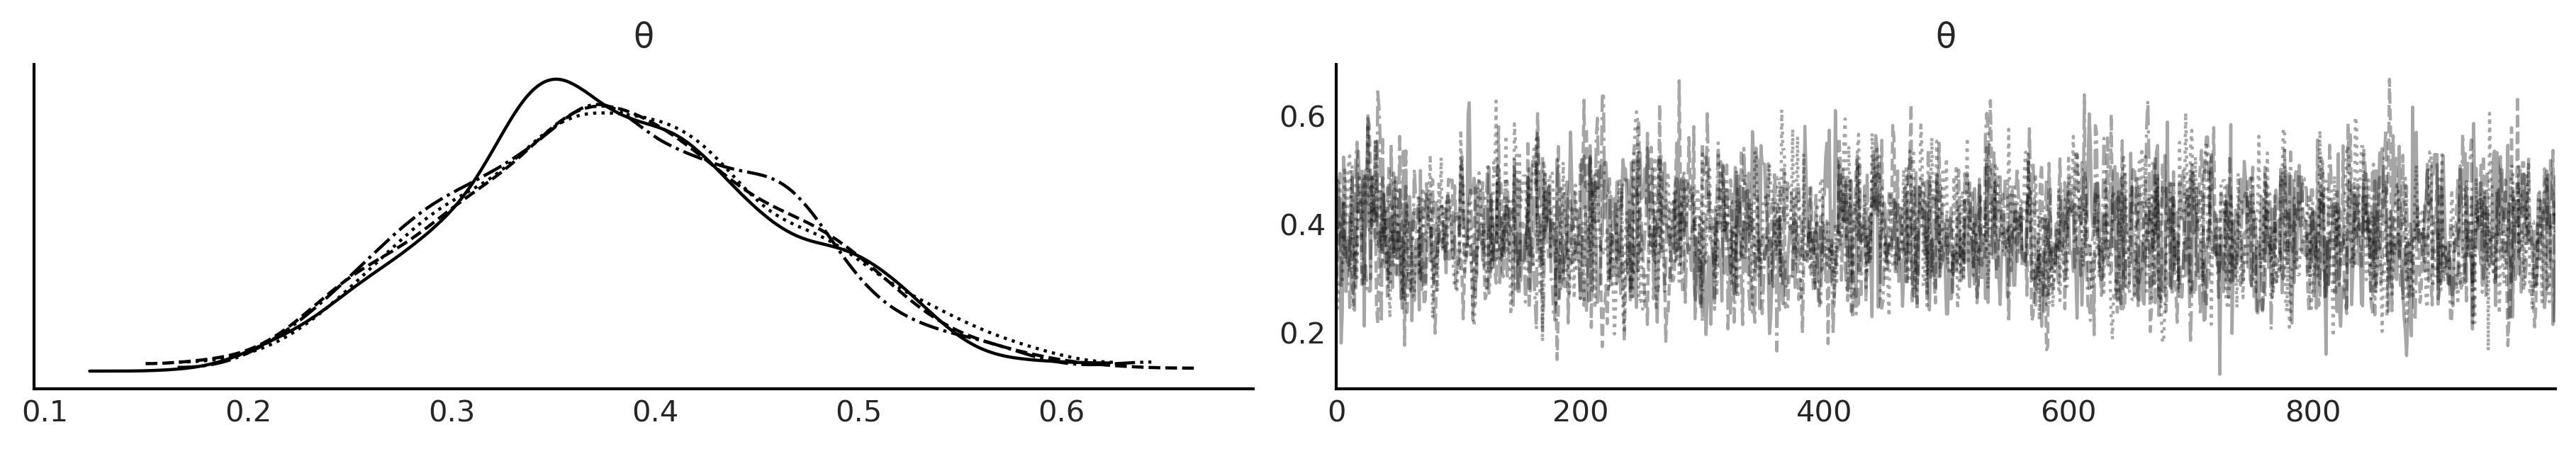

In [5]:
az.plot_trace(idata)

array([[<Axes: title={'center': 'θ'}>,
        <Axes: title={'center': 'θ'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

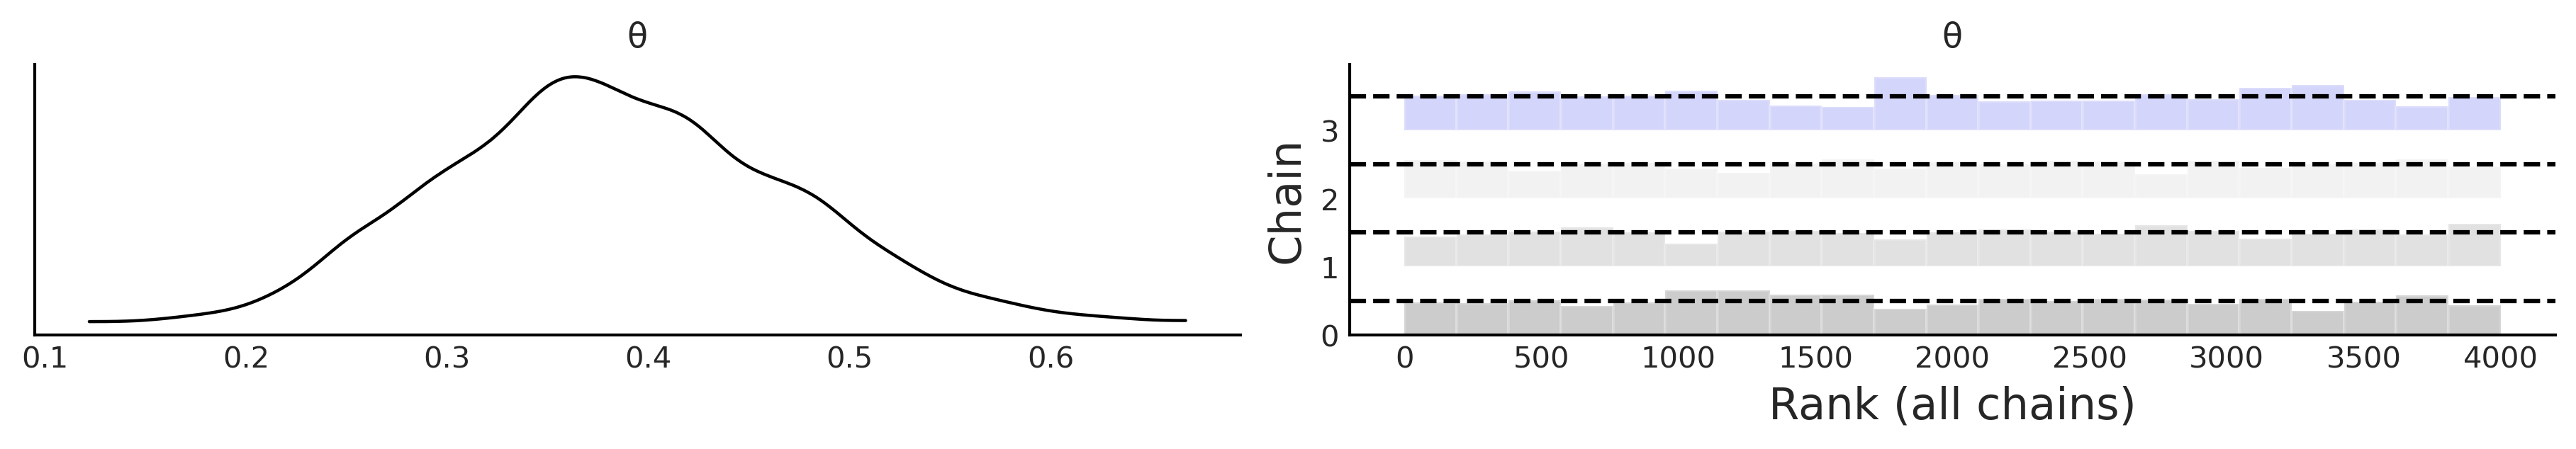

In [6]:
az.plot_trace(idata, kind="rank_bars", combined=True)

In [7]:
az.summary(idata, kind="stats").round(2)

mean    sd  hdi_3%  hdi_97%
θ  0.38  0.08    0.23     0.54

<Axes: title={'center': 'θ'}>

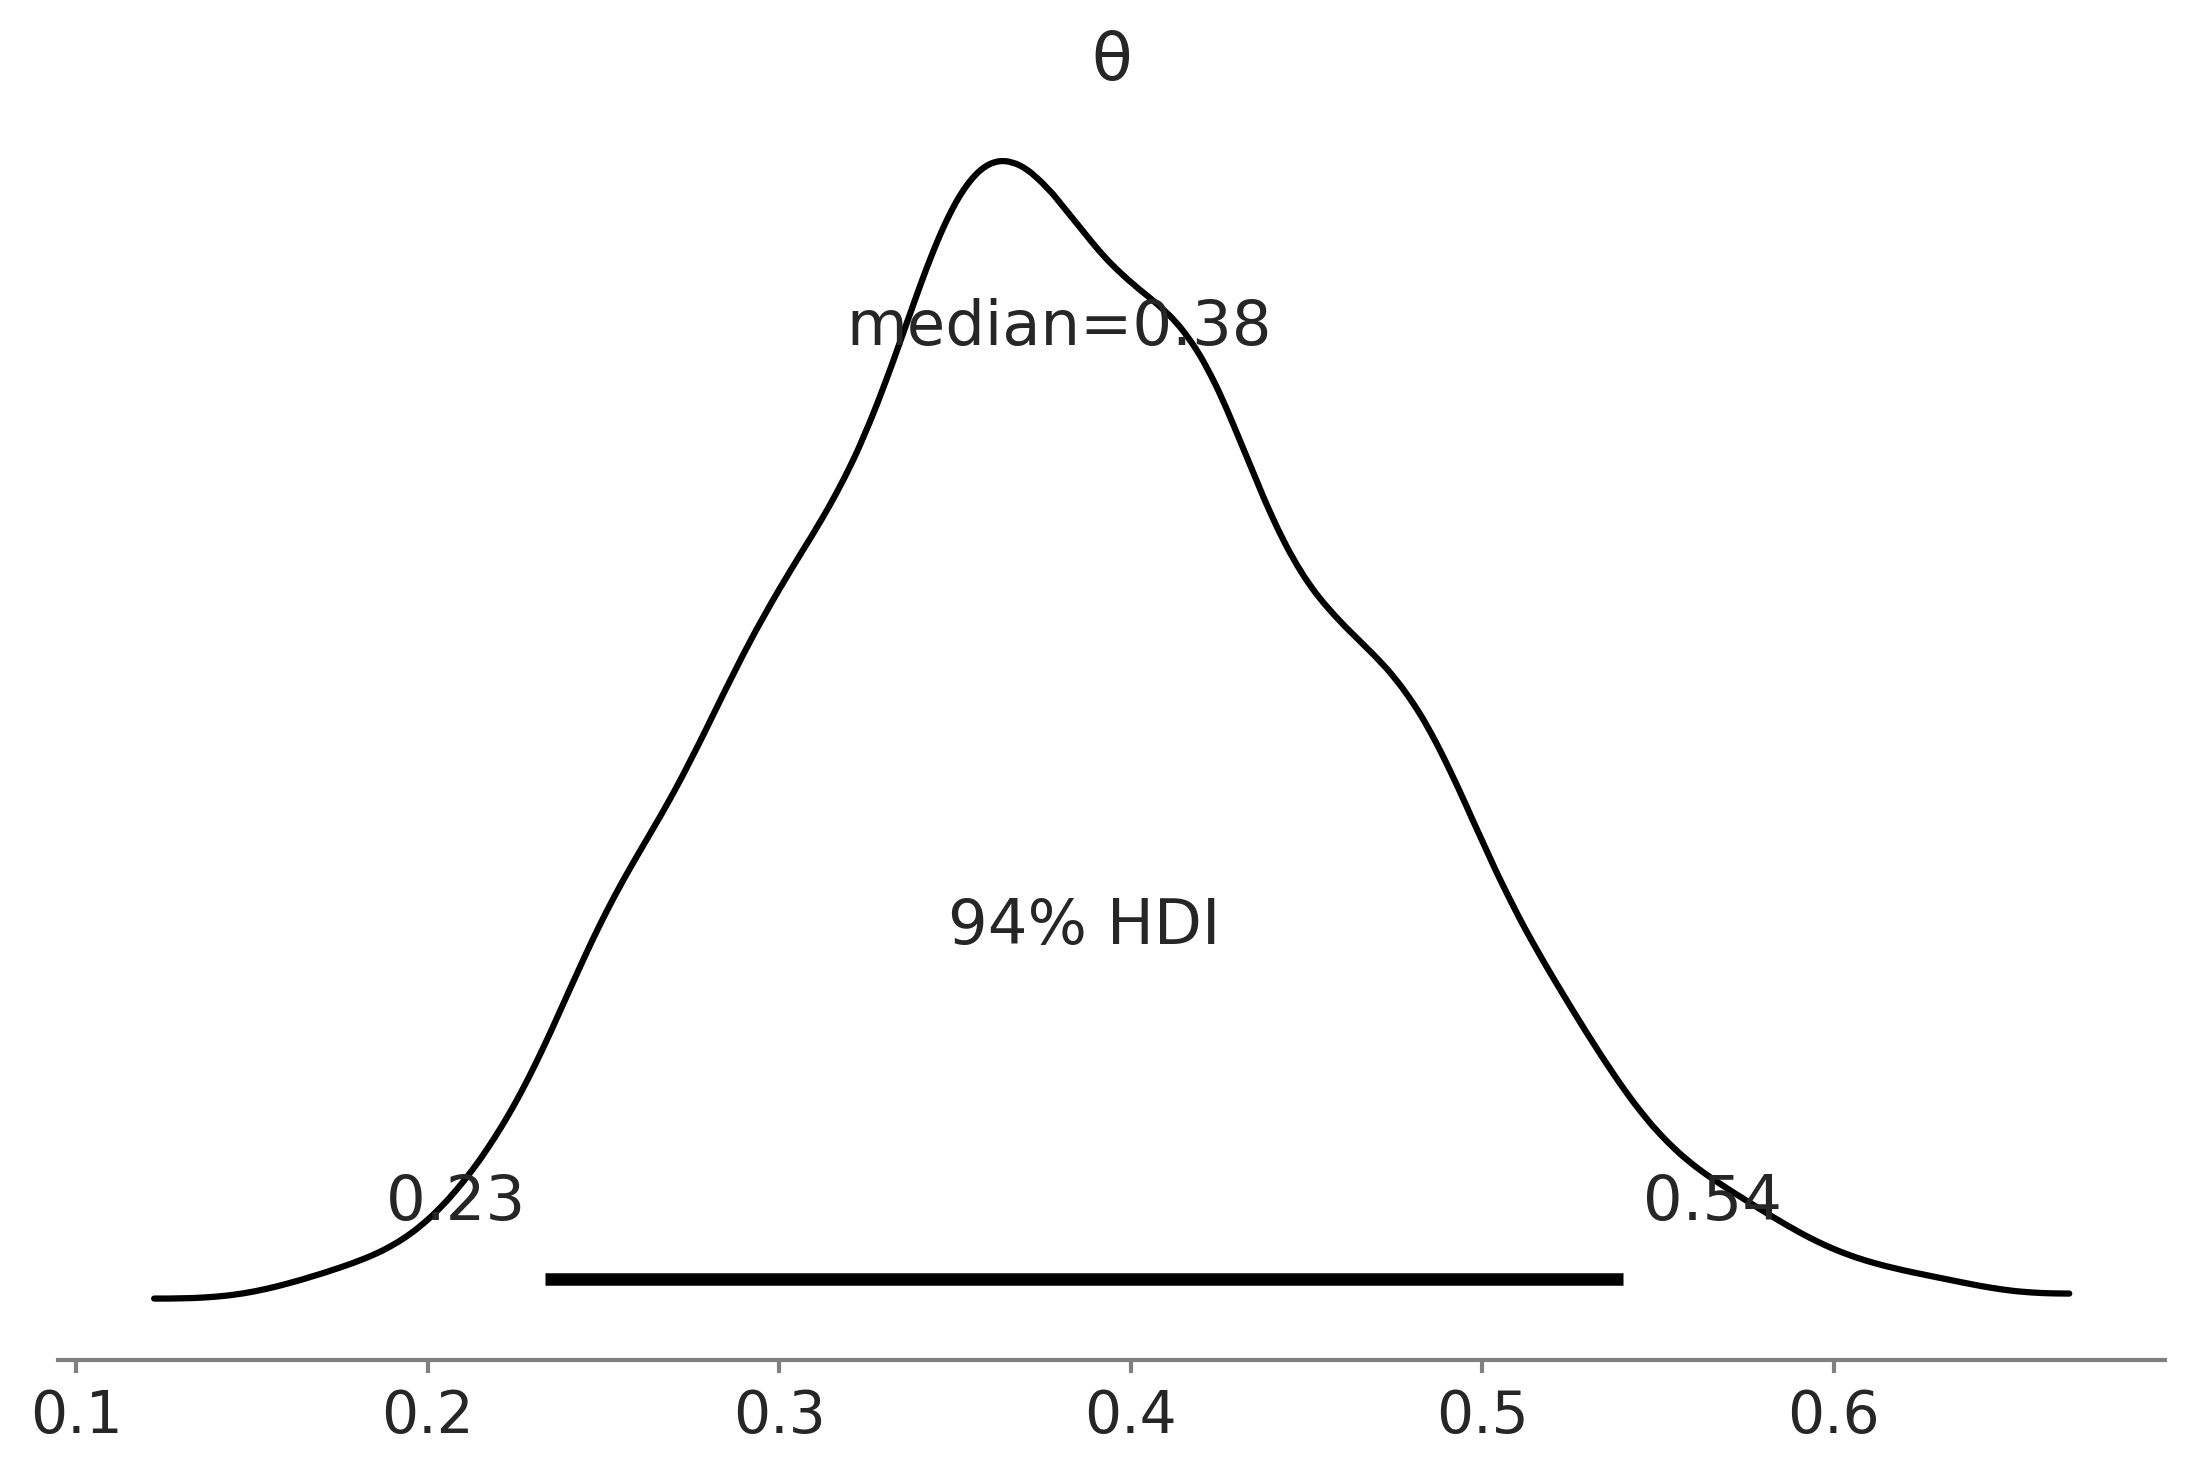

In [8]:
az.plot_posterior(idata, point_estimate="median", hdi_prob=.94)

({'BF10': 0.508513792123032, 'BF01': 1.966515000163566},
 <Axes: title={'center': 'The BF_10 is 0.51\nThe BF_01 is 1.97'}, xlabel='θ', ylabel='Density'>)

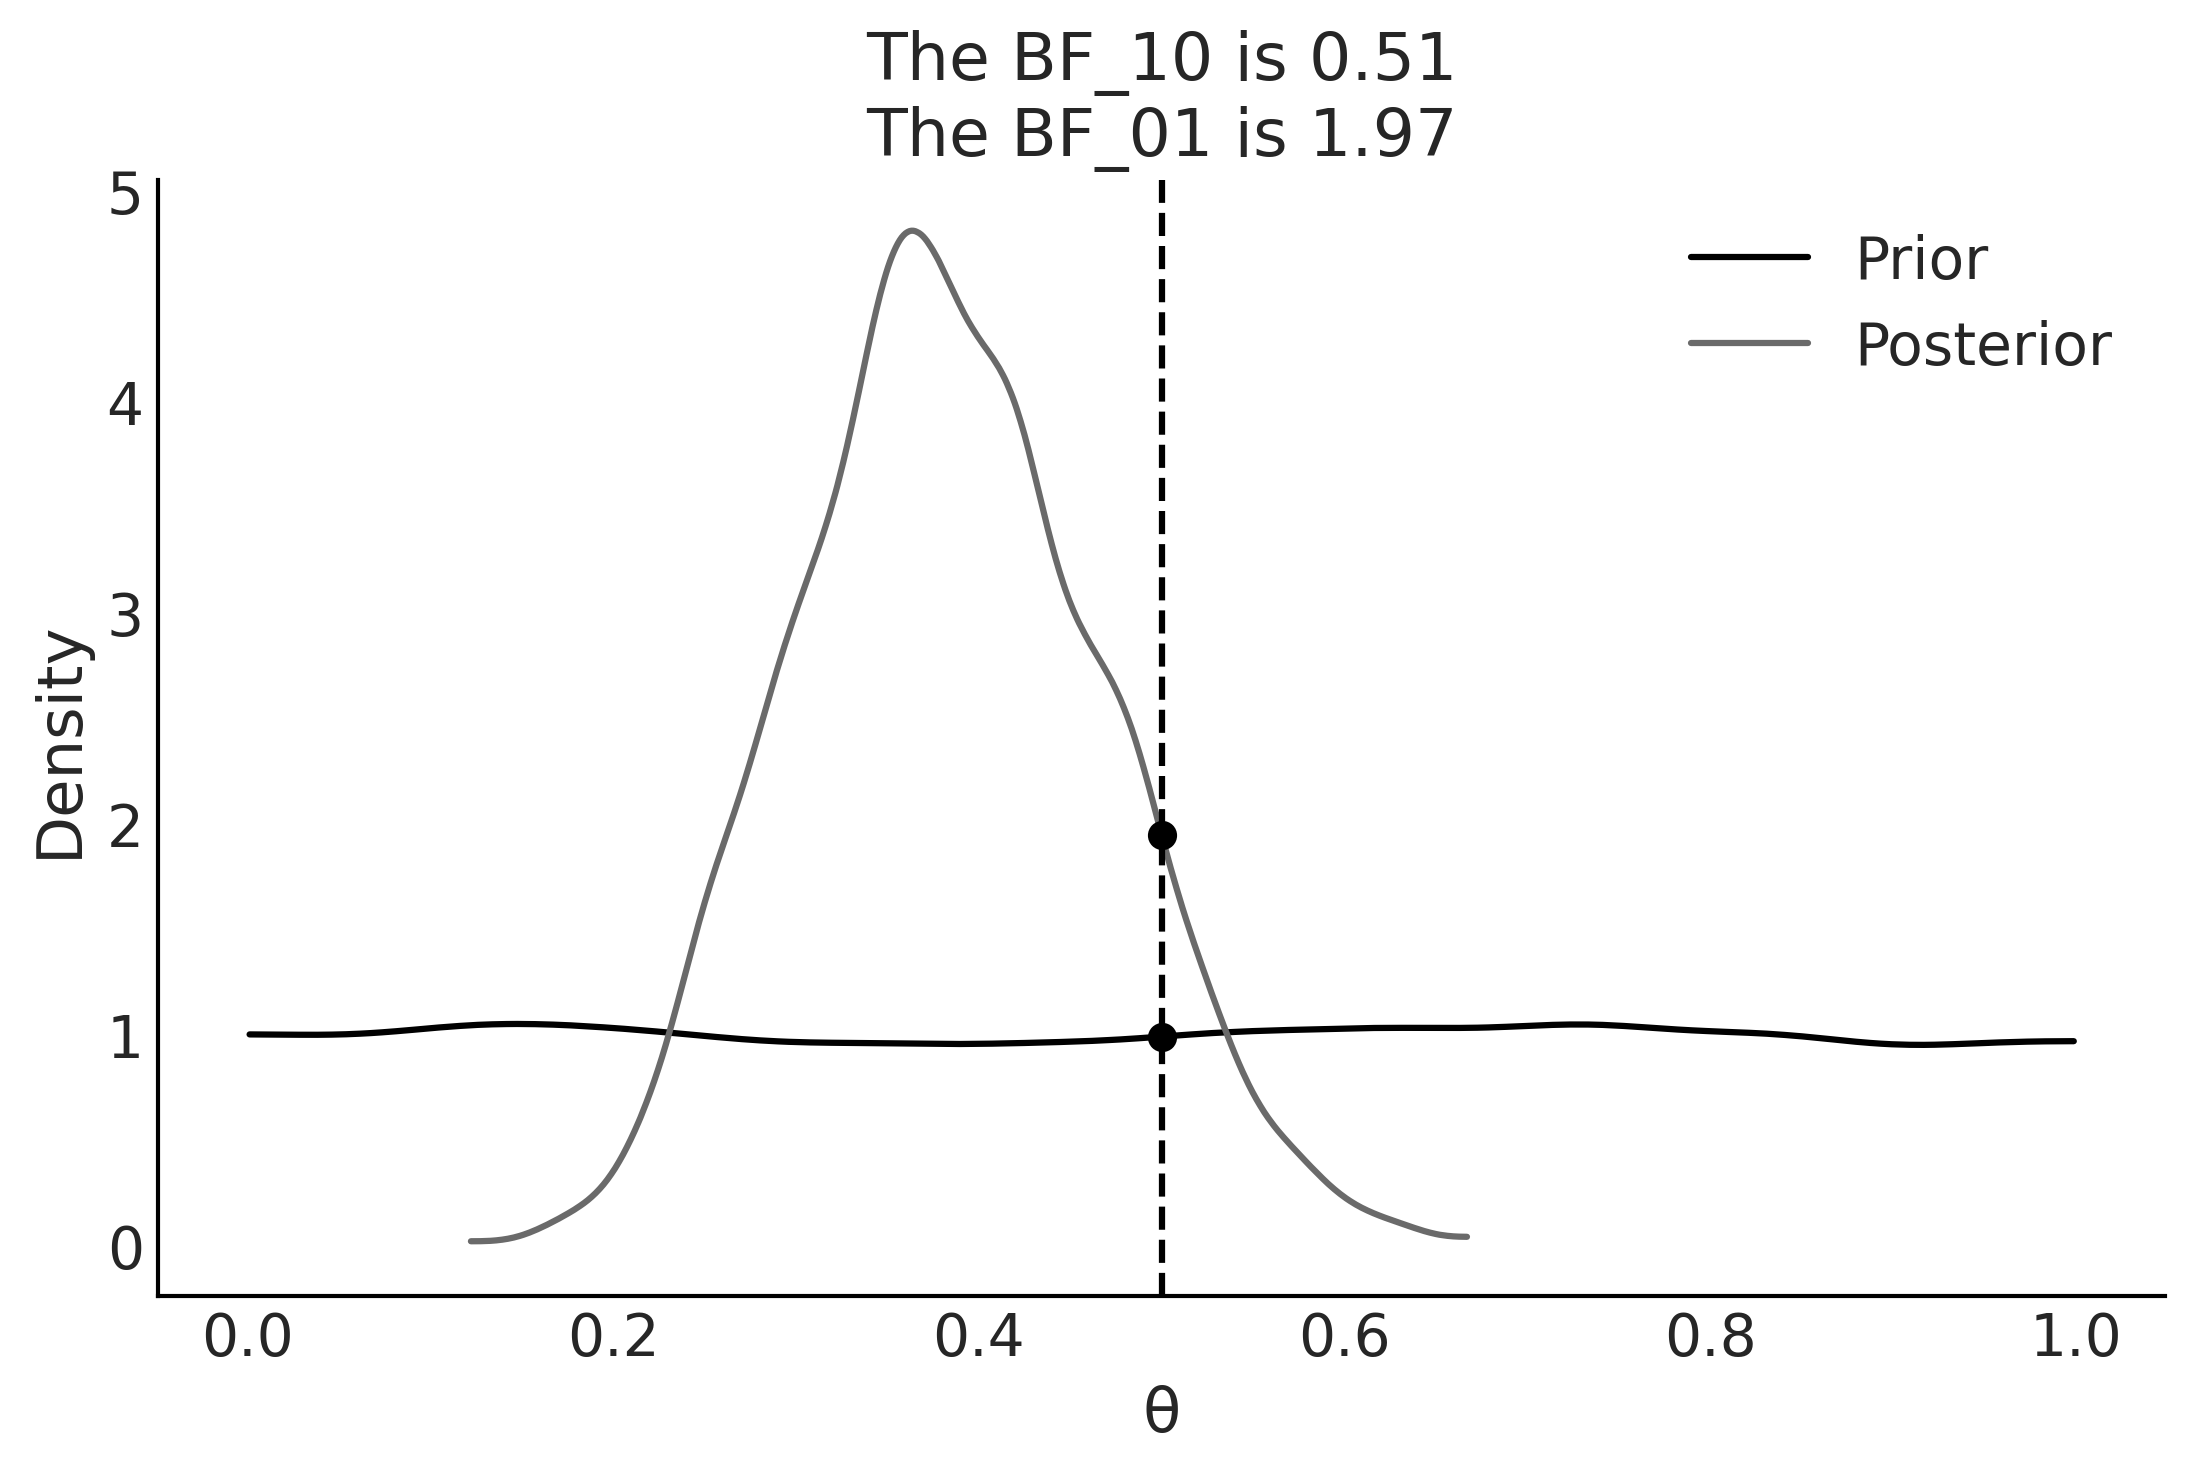

In [9]:
az.plot_bf(idata, var_name="θ",
           prior=np.random.uniform(0, 1, 10_000), ref_val=0.5)

<Axes: title={'center': 'θ'}>

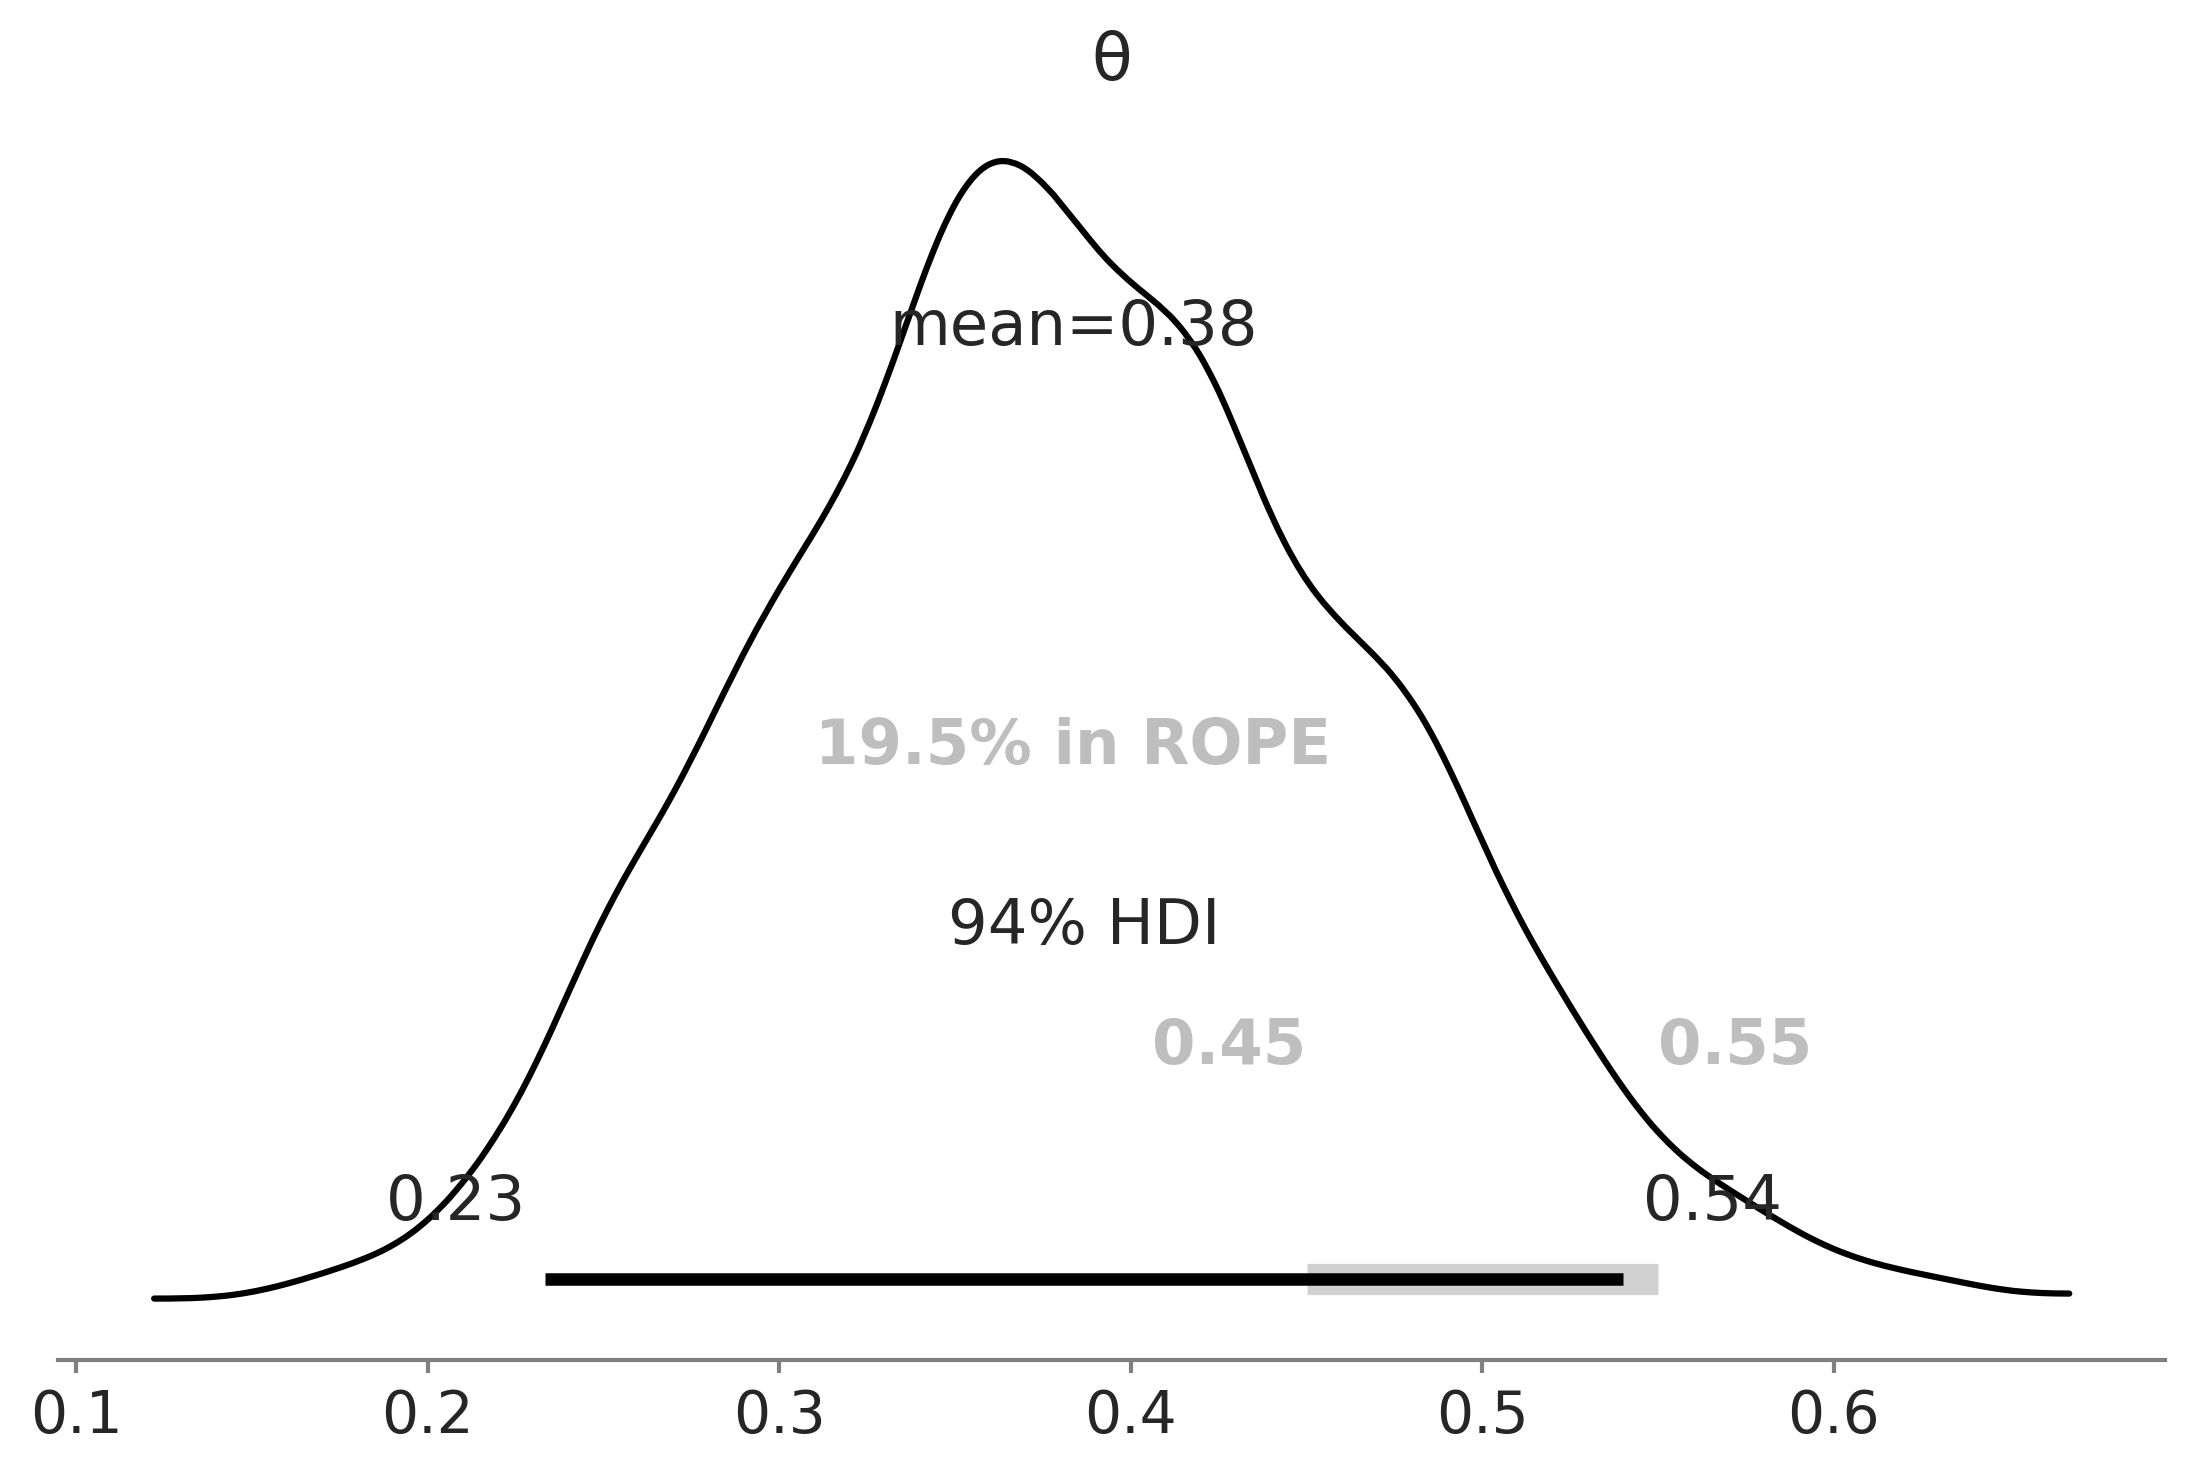

In [10]:
az.plot_posterior(idata, rope=[0.45, 0.55])

<Axes: title={'center': 'θ'}>

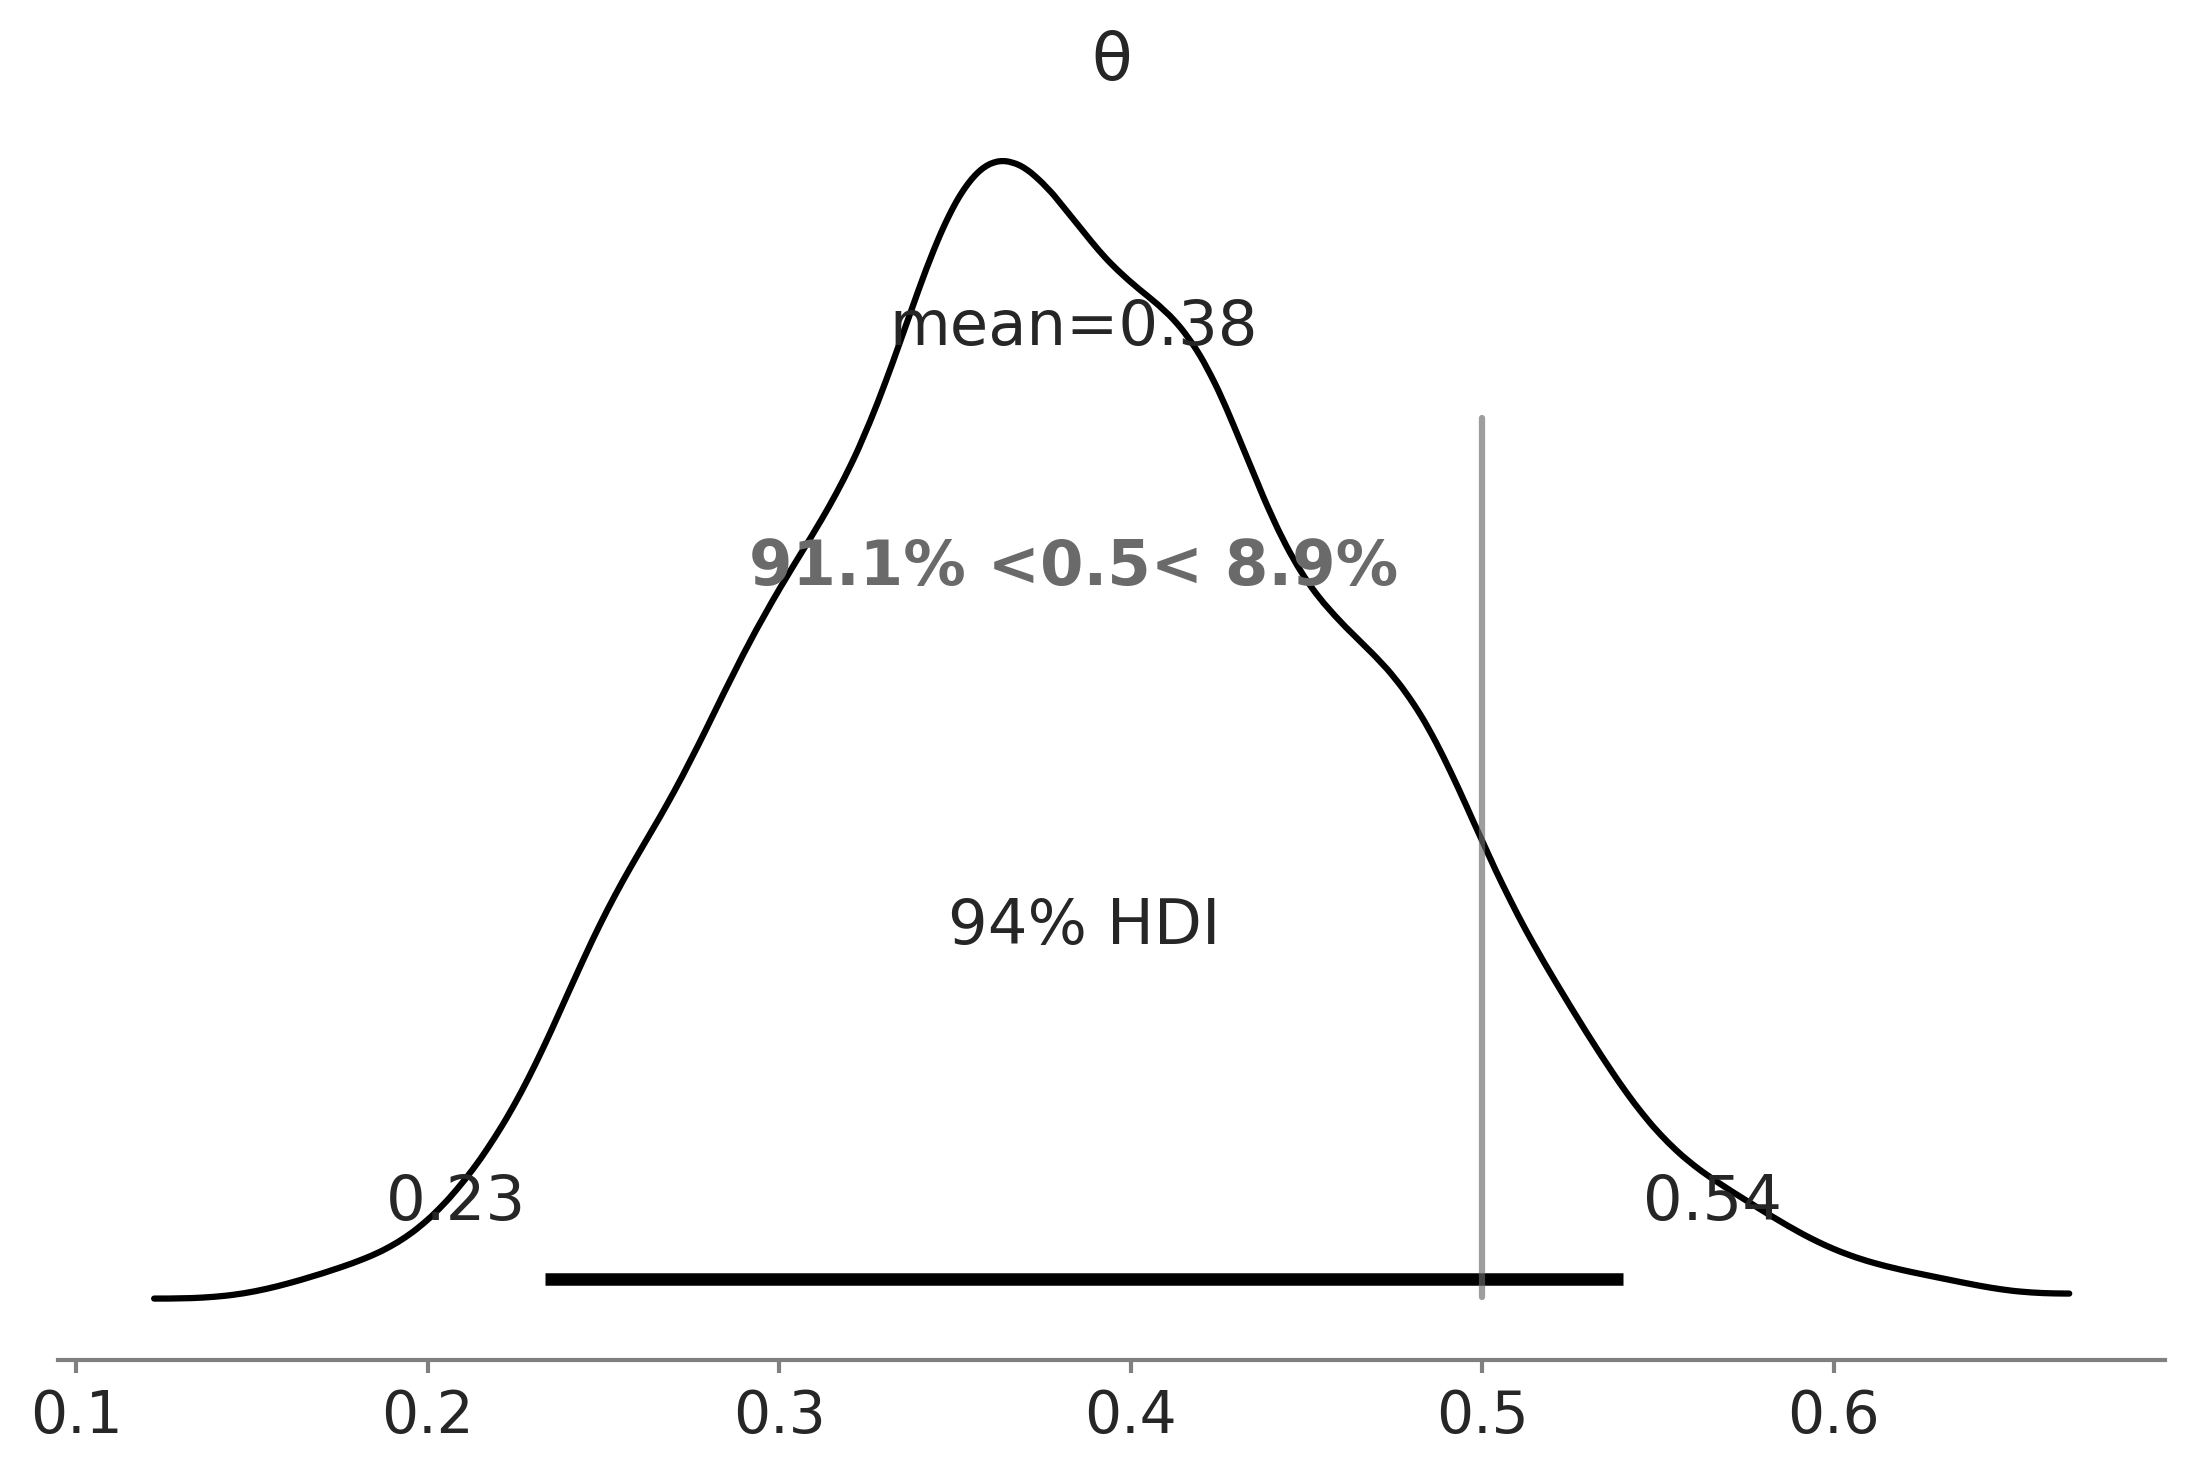

In [11]:
az.plot_posterior(idata, ref_val=0.5)

In [12]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior["θ"]
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
print(grid[np.argmin(lossf_a)])
print(grid[np.argmin(lossf_b)])

0.38190954773869346
0.38190954773869346


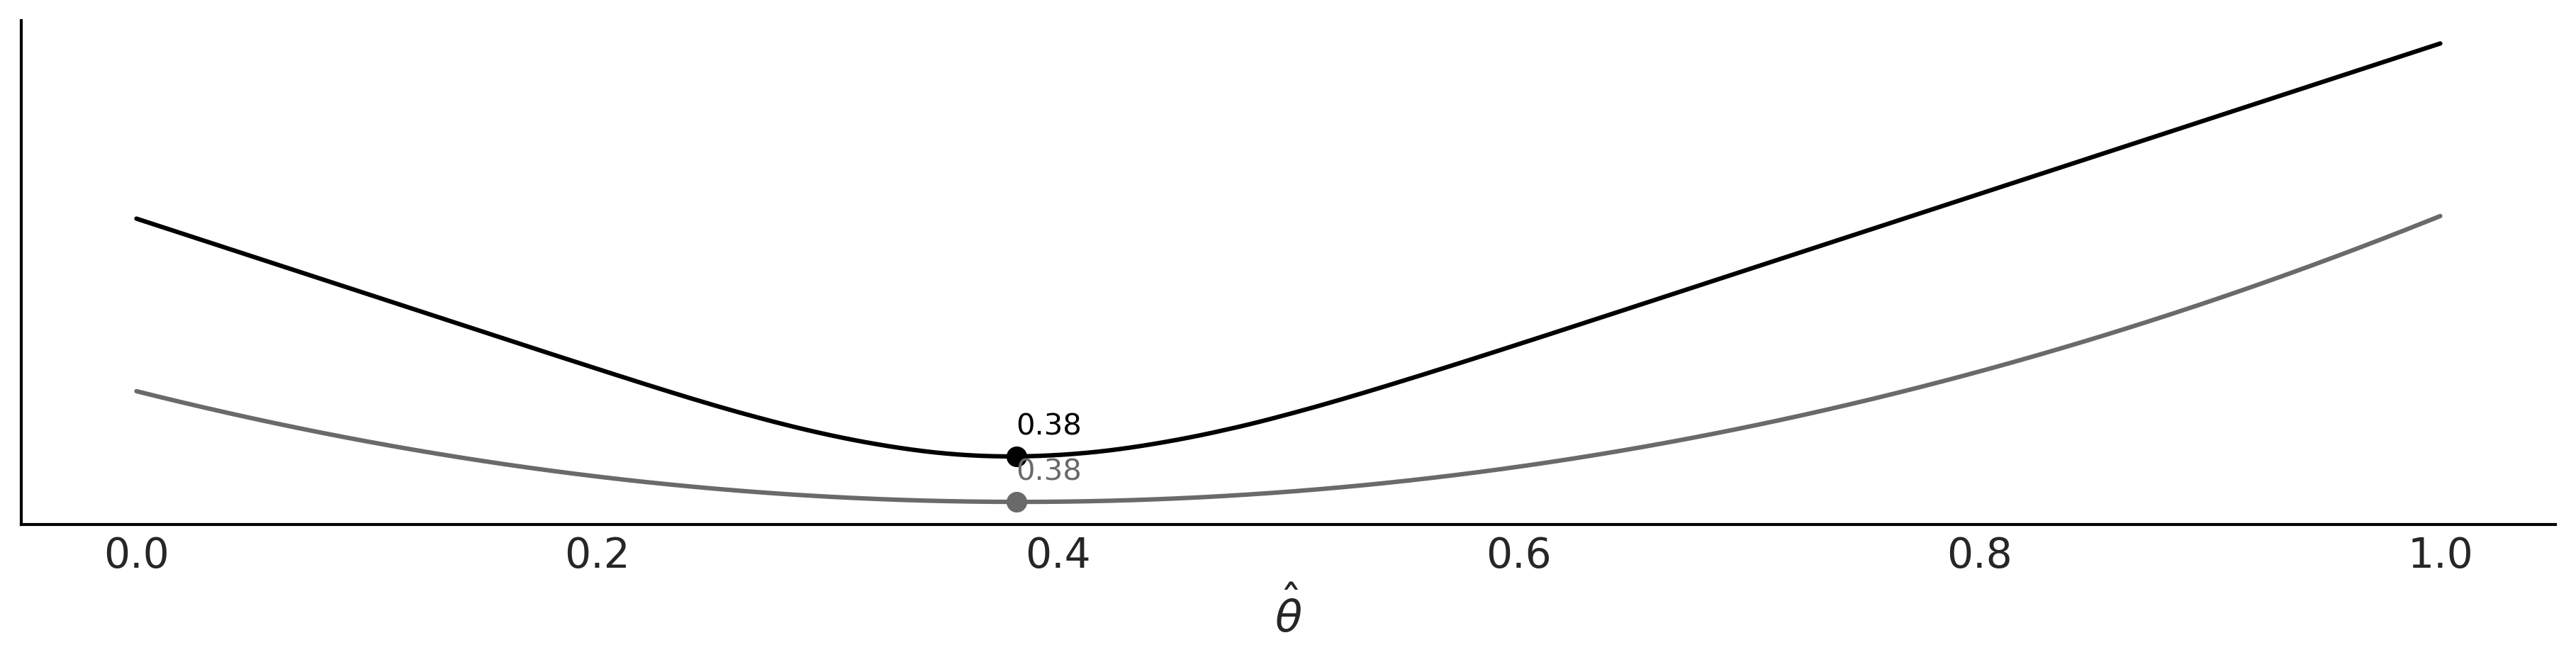

In [13]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]
_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)

    ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')

{'whiskers': [<matplotlib.lines.Line2D at 0x7644e3b4a1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7644e3b82f50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7644e3bc9f10>],
 'medians': [<matplotlib.lines.Line2D at 0x7644e3b0bb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7644e3c5add0>],
 'means': []}

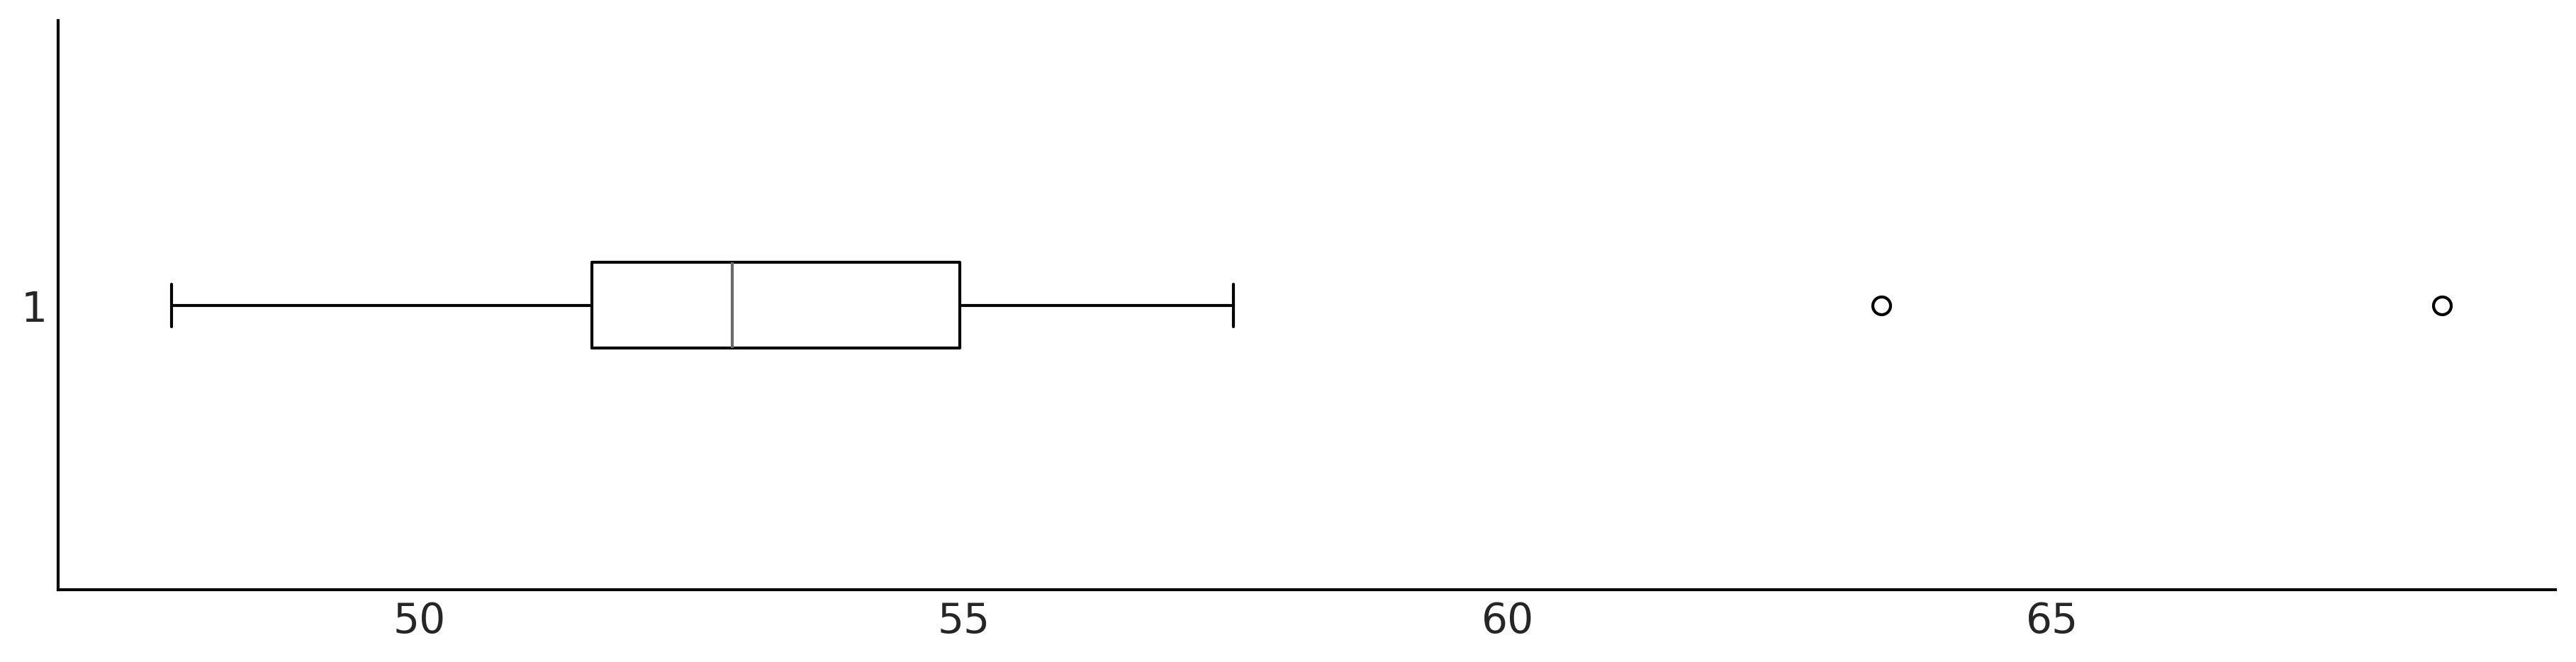

In [14]:
data = np.loadtxt("chemical_shifts.csv")
_, ax = plt.subplots(figsize=(12, 3))
ax.boxplot(data, vert=False)

In [15]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)
    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

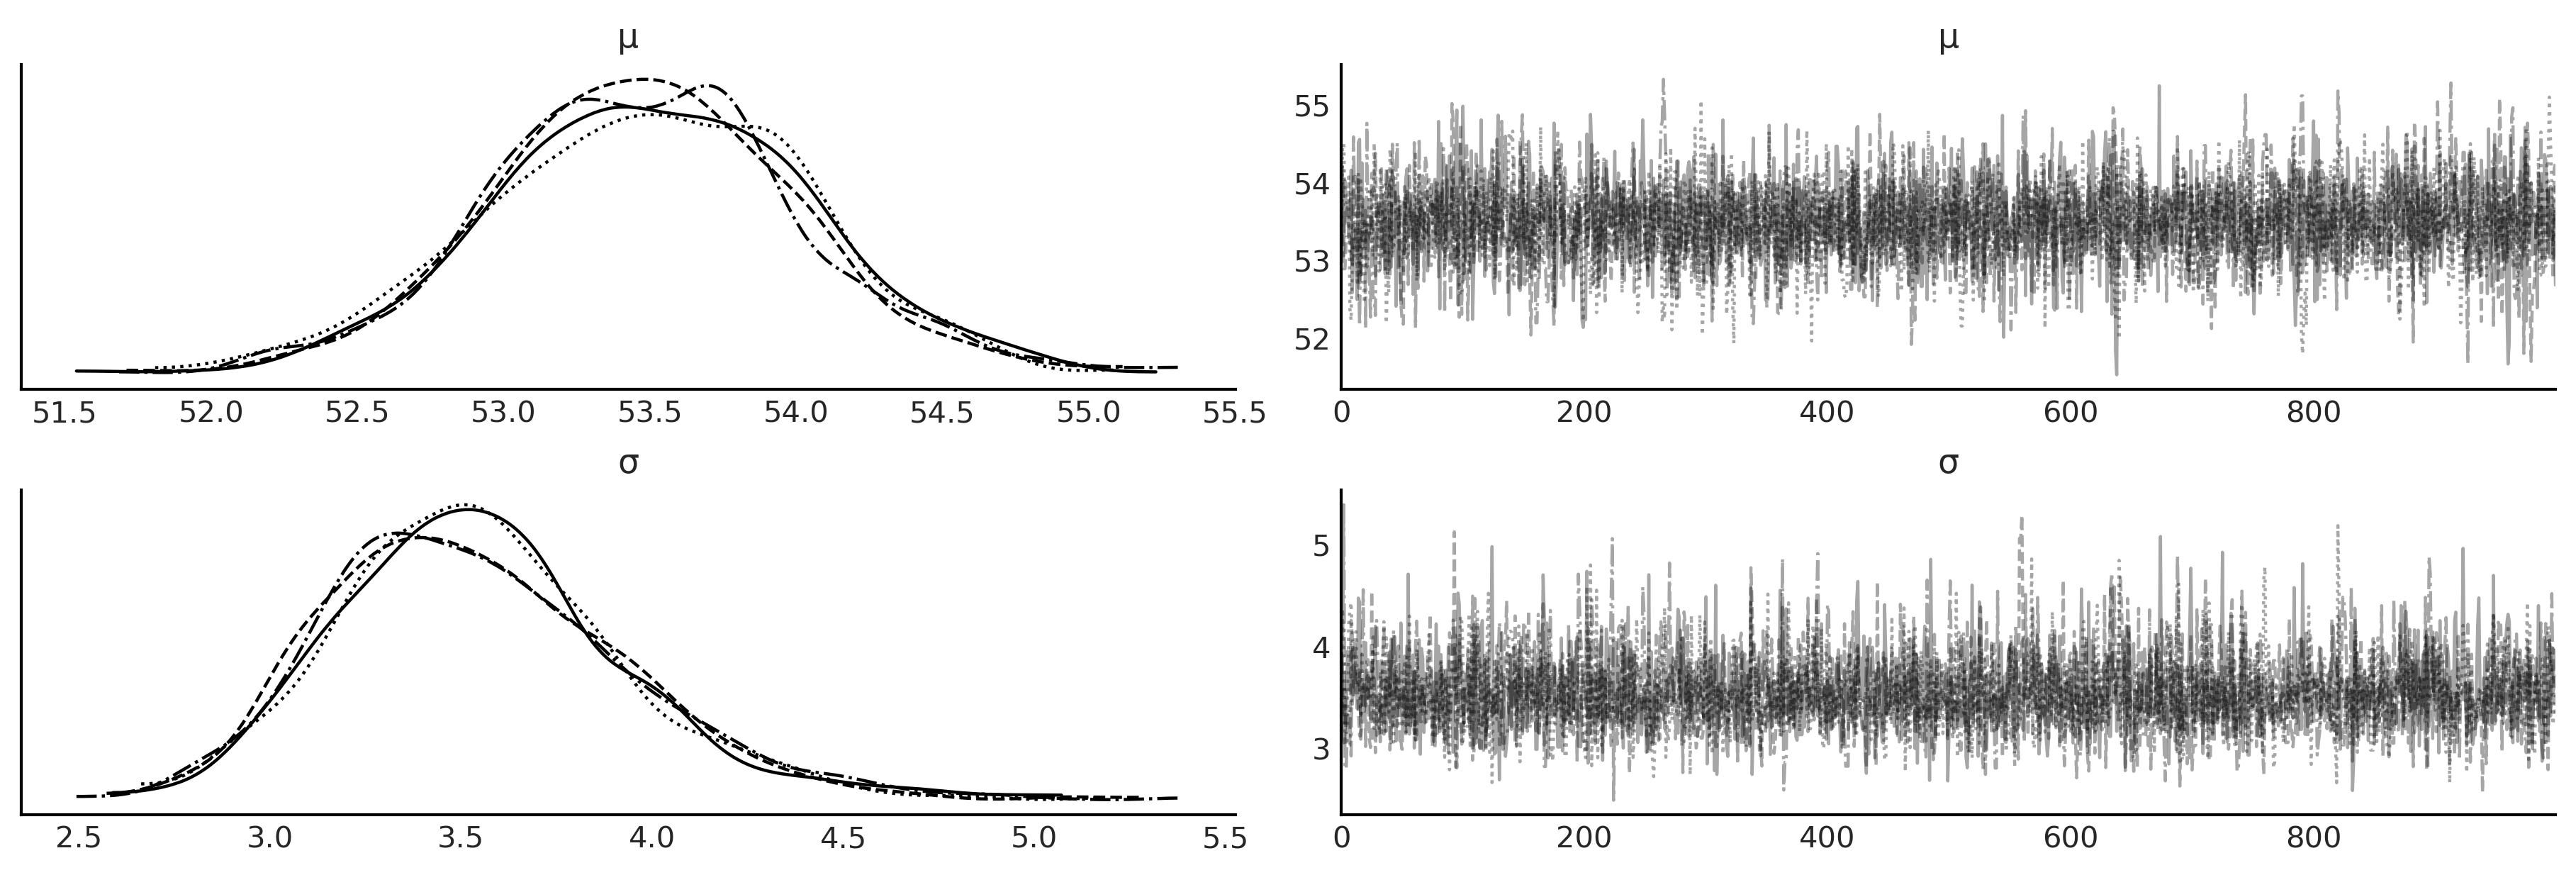

In [16]:
az.plot_trace(idata_g)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

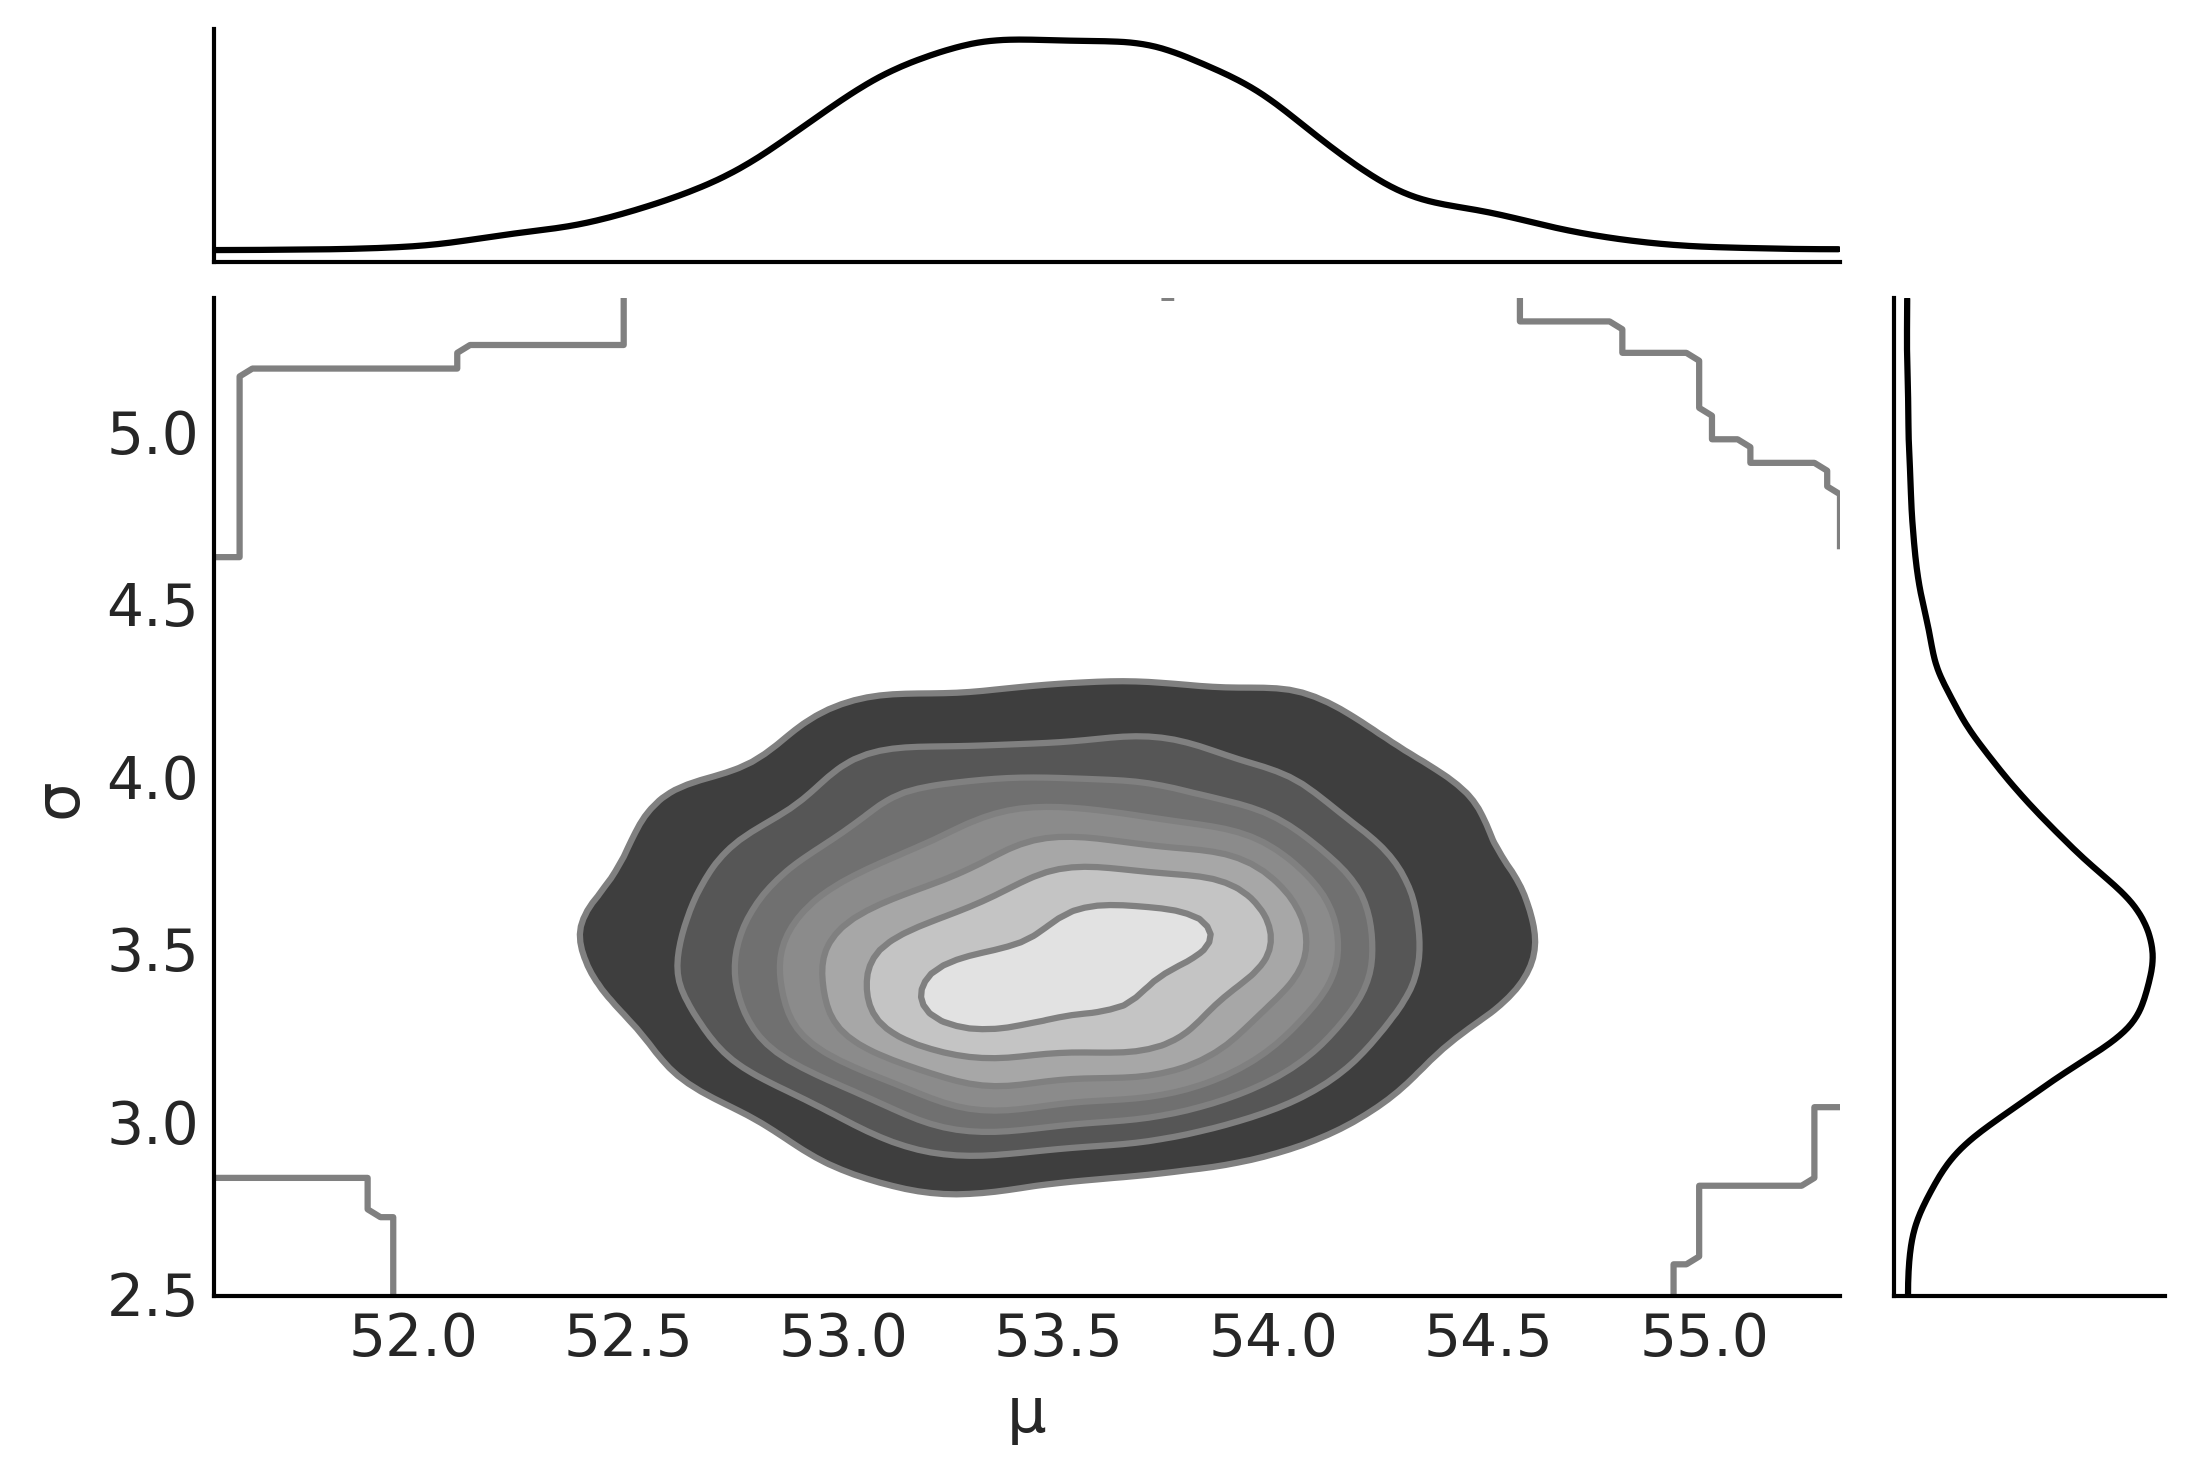

In [17]:
az.plot_pair(idata_g, kind='kde', marginals=True)

In [18]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)

Sampling: [Y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

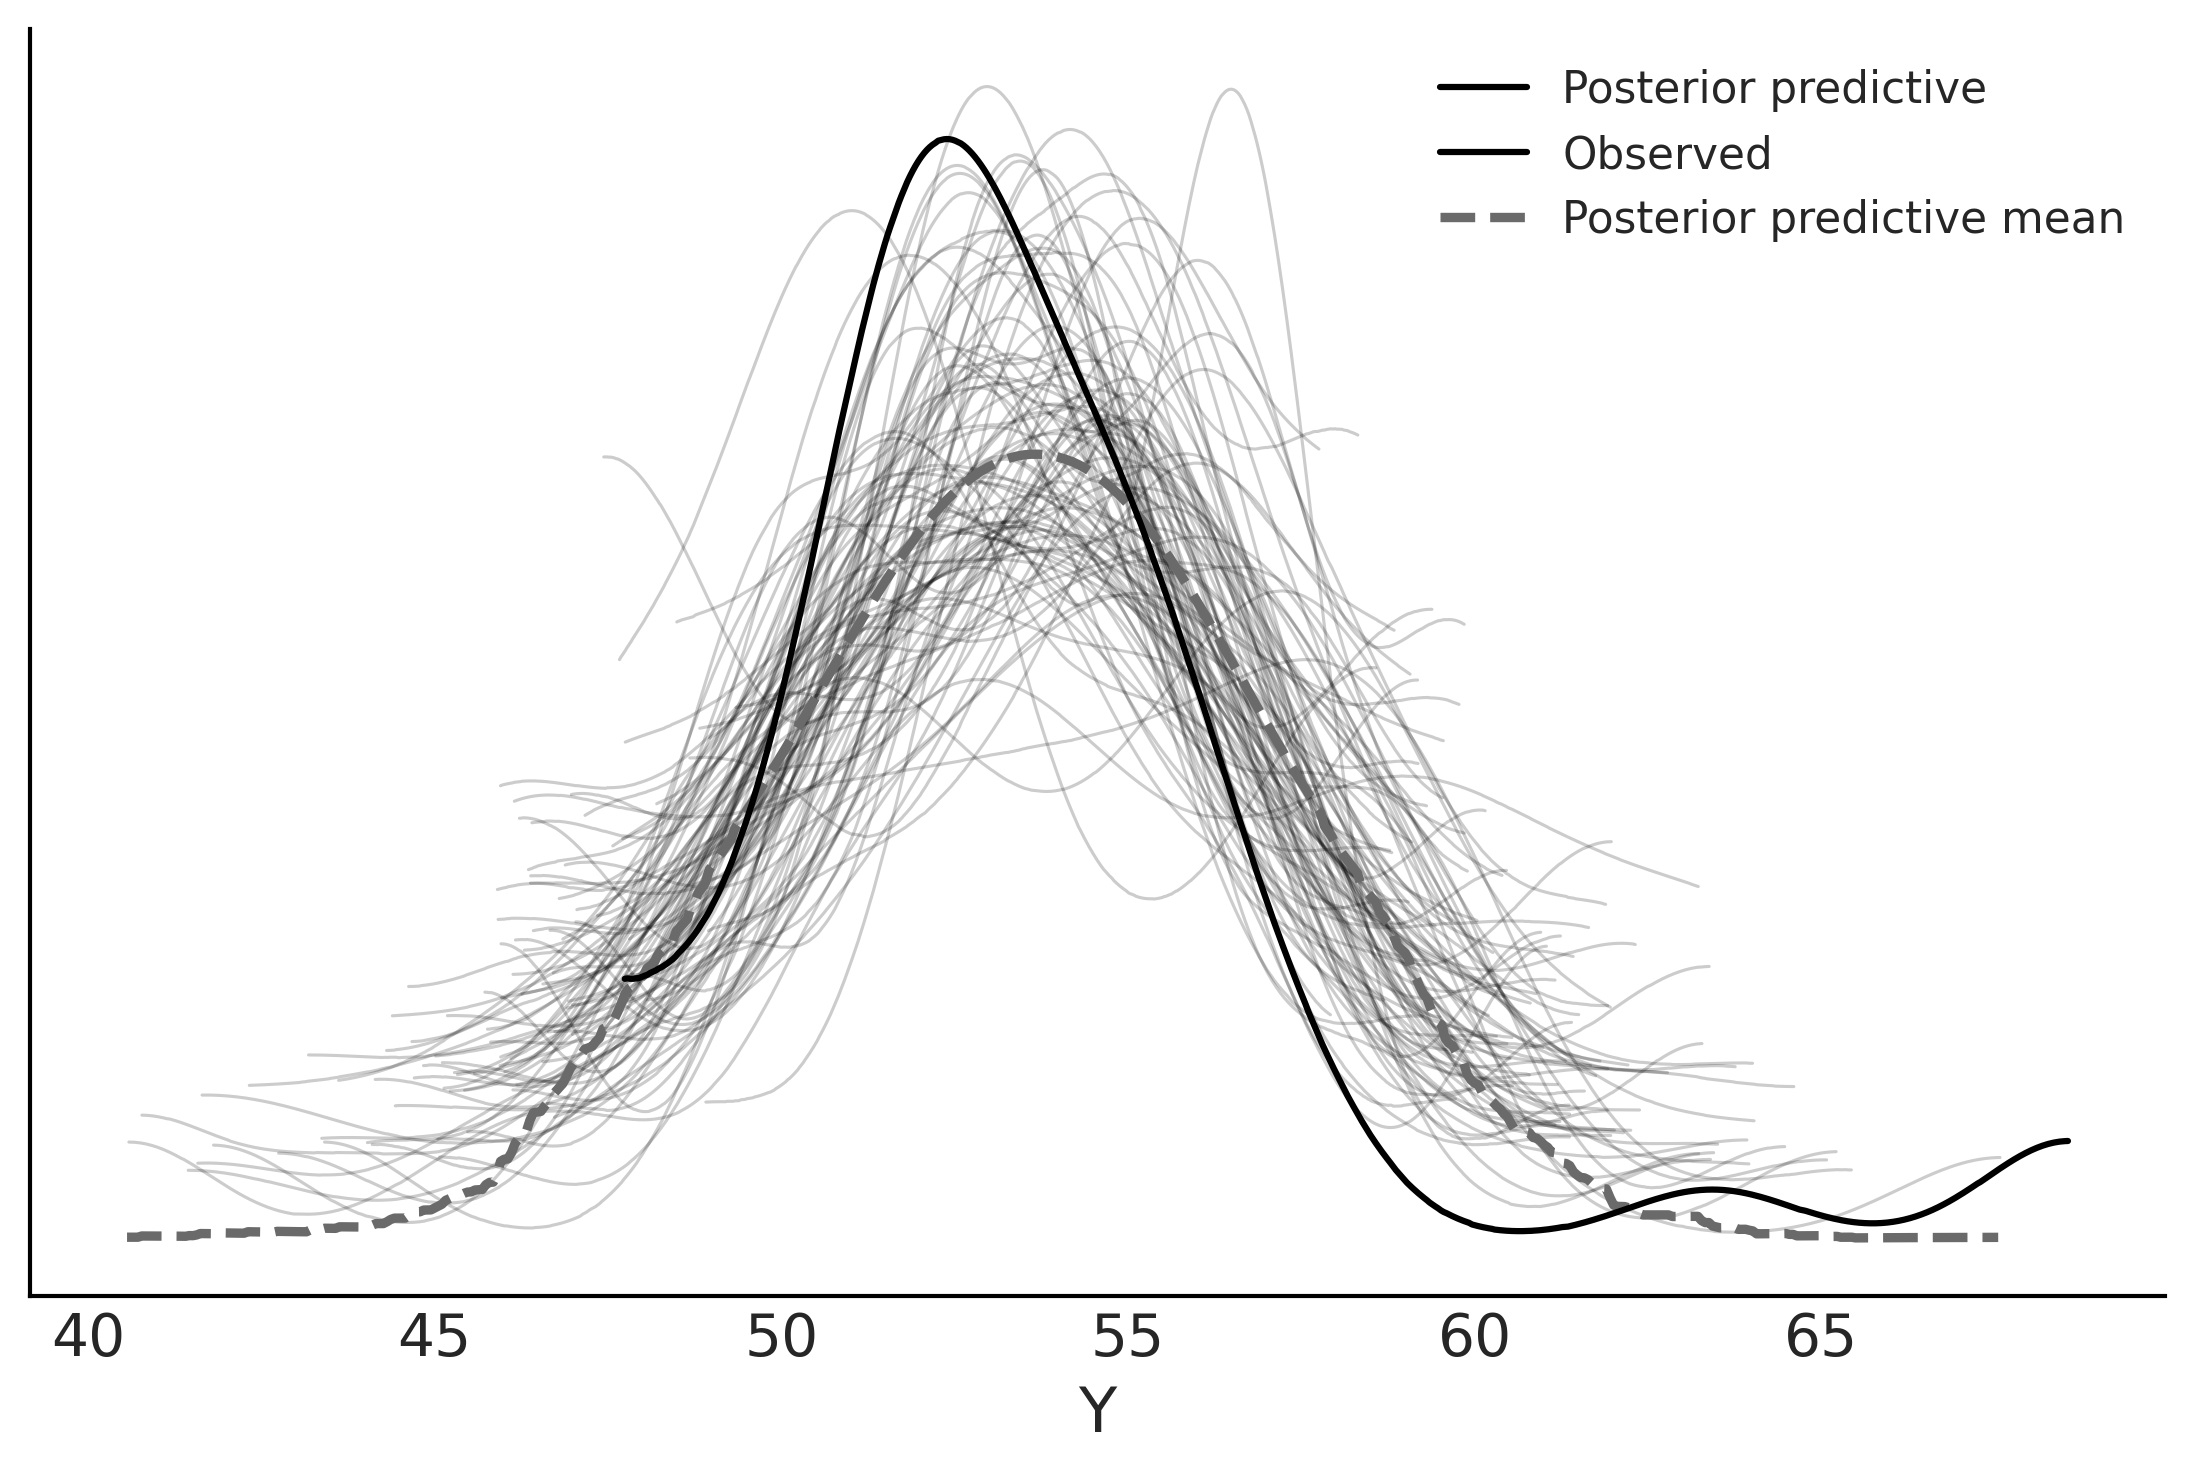

In [19]:
az.plot_ppc(idata_g, num_pp_samples=100)

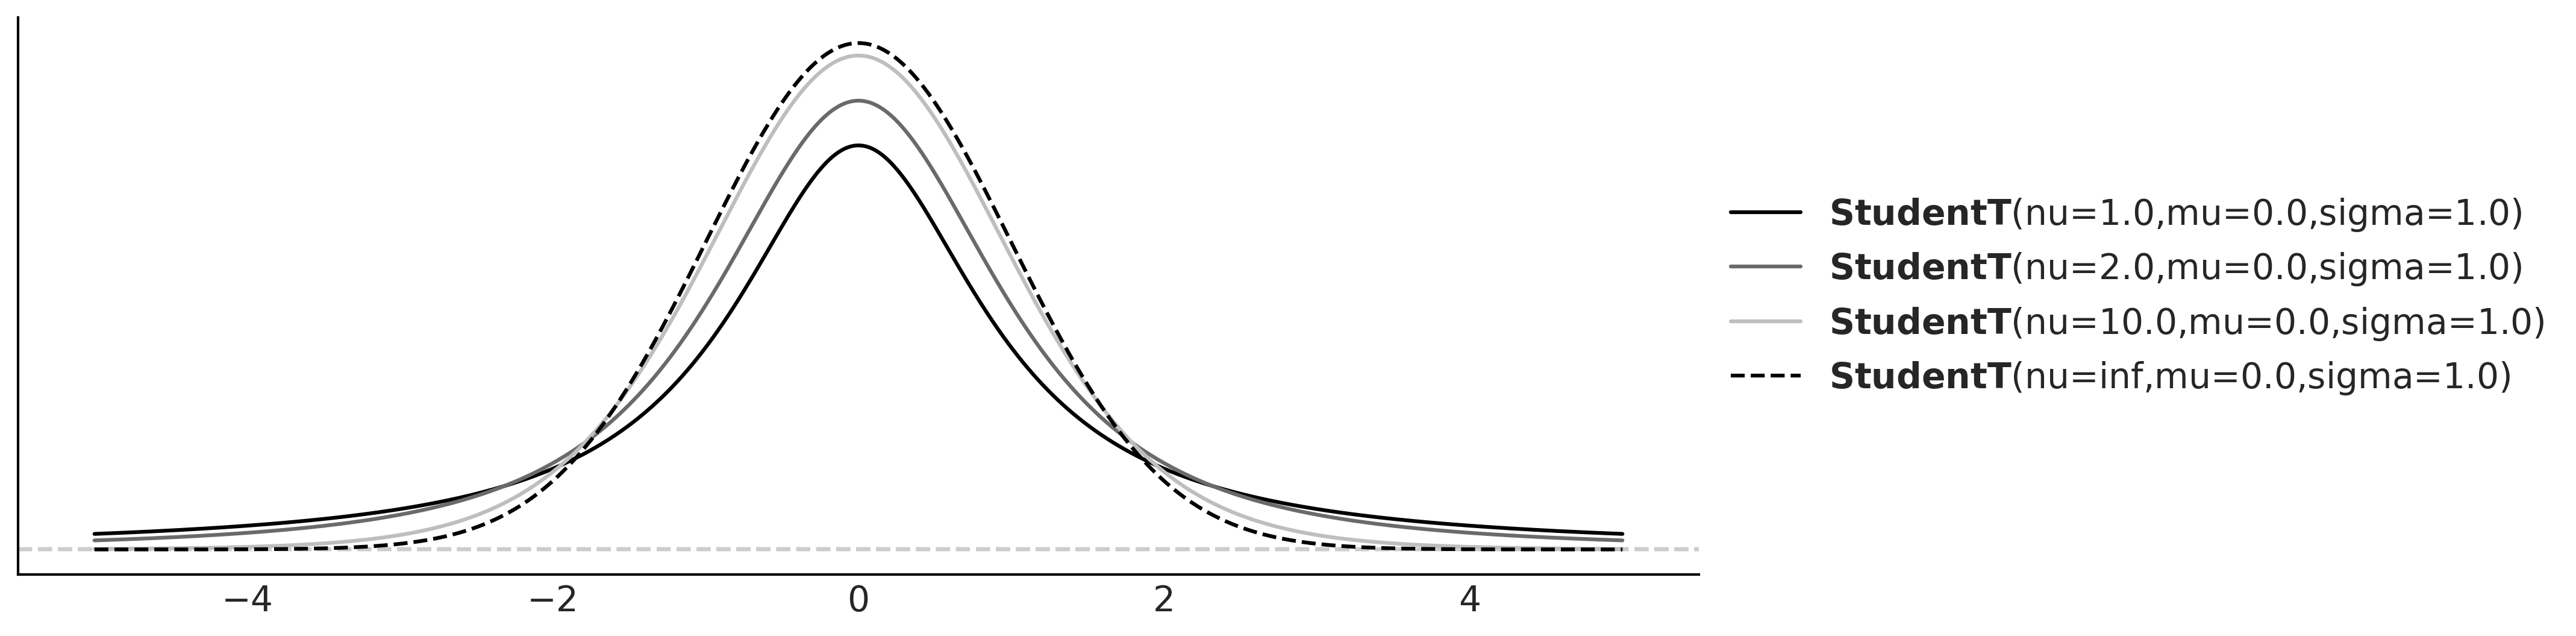

In [20]:
for nu in [1, 2, 10]:
    pz.StudentT(nu, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4))

ax = pz.StudentT(np.inf, 0, 1).plot_pdf(support=(-5, 5), figsize=(12, 4), color="k")
ax.get_lines()[-1].set_linestyle("--")
pz.internal.plot_helper.side_legend(ax)

In [21]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', nu=ν, mu=μ, sigma=σ, observed=data)
    idata_t = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ν]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

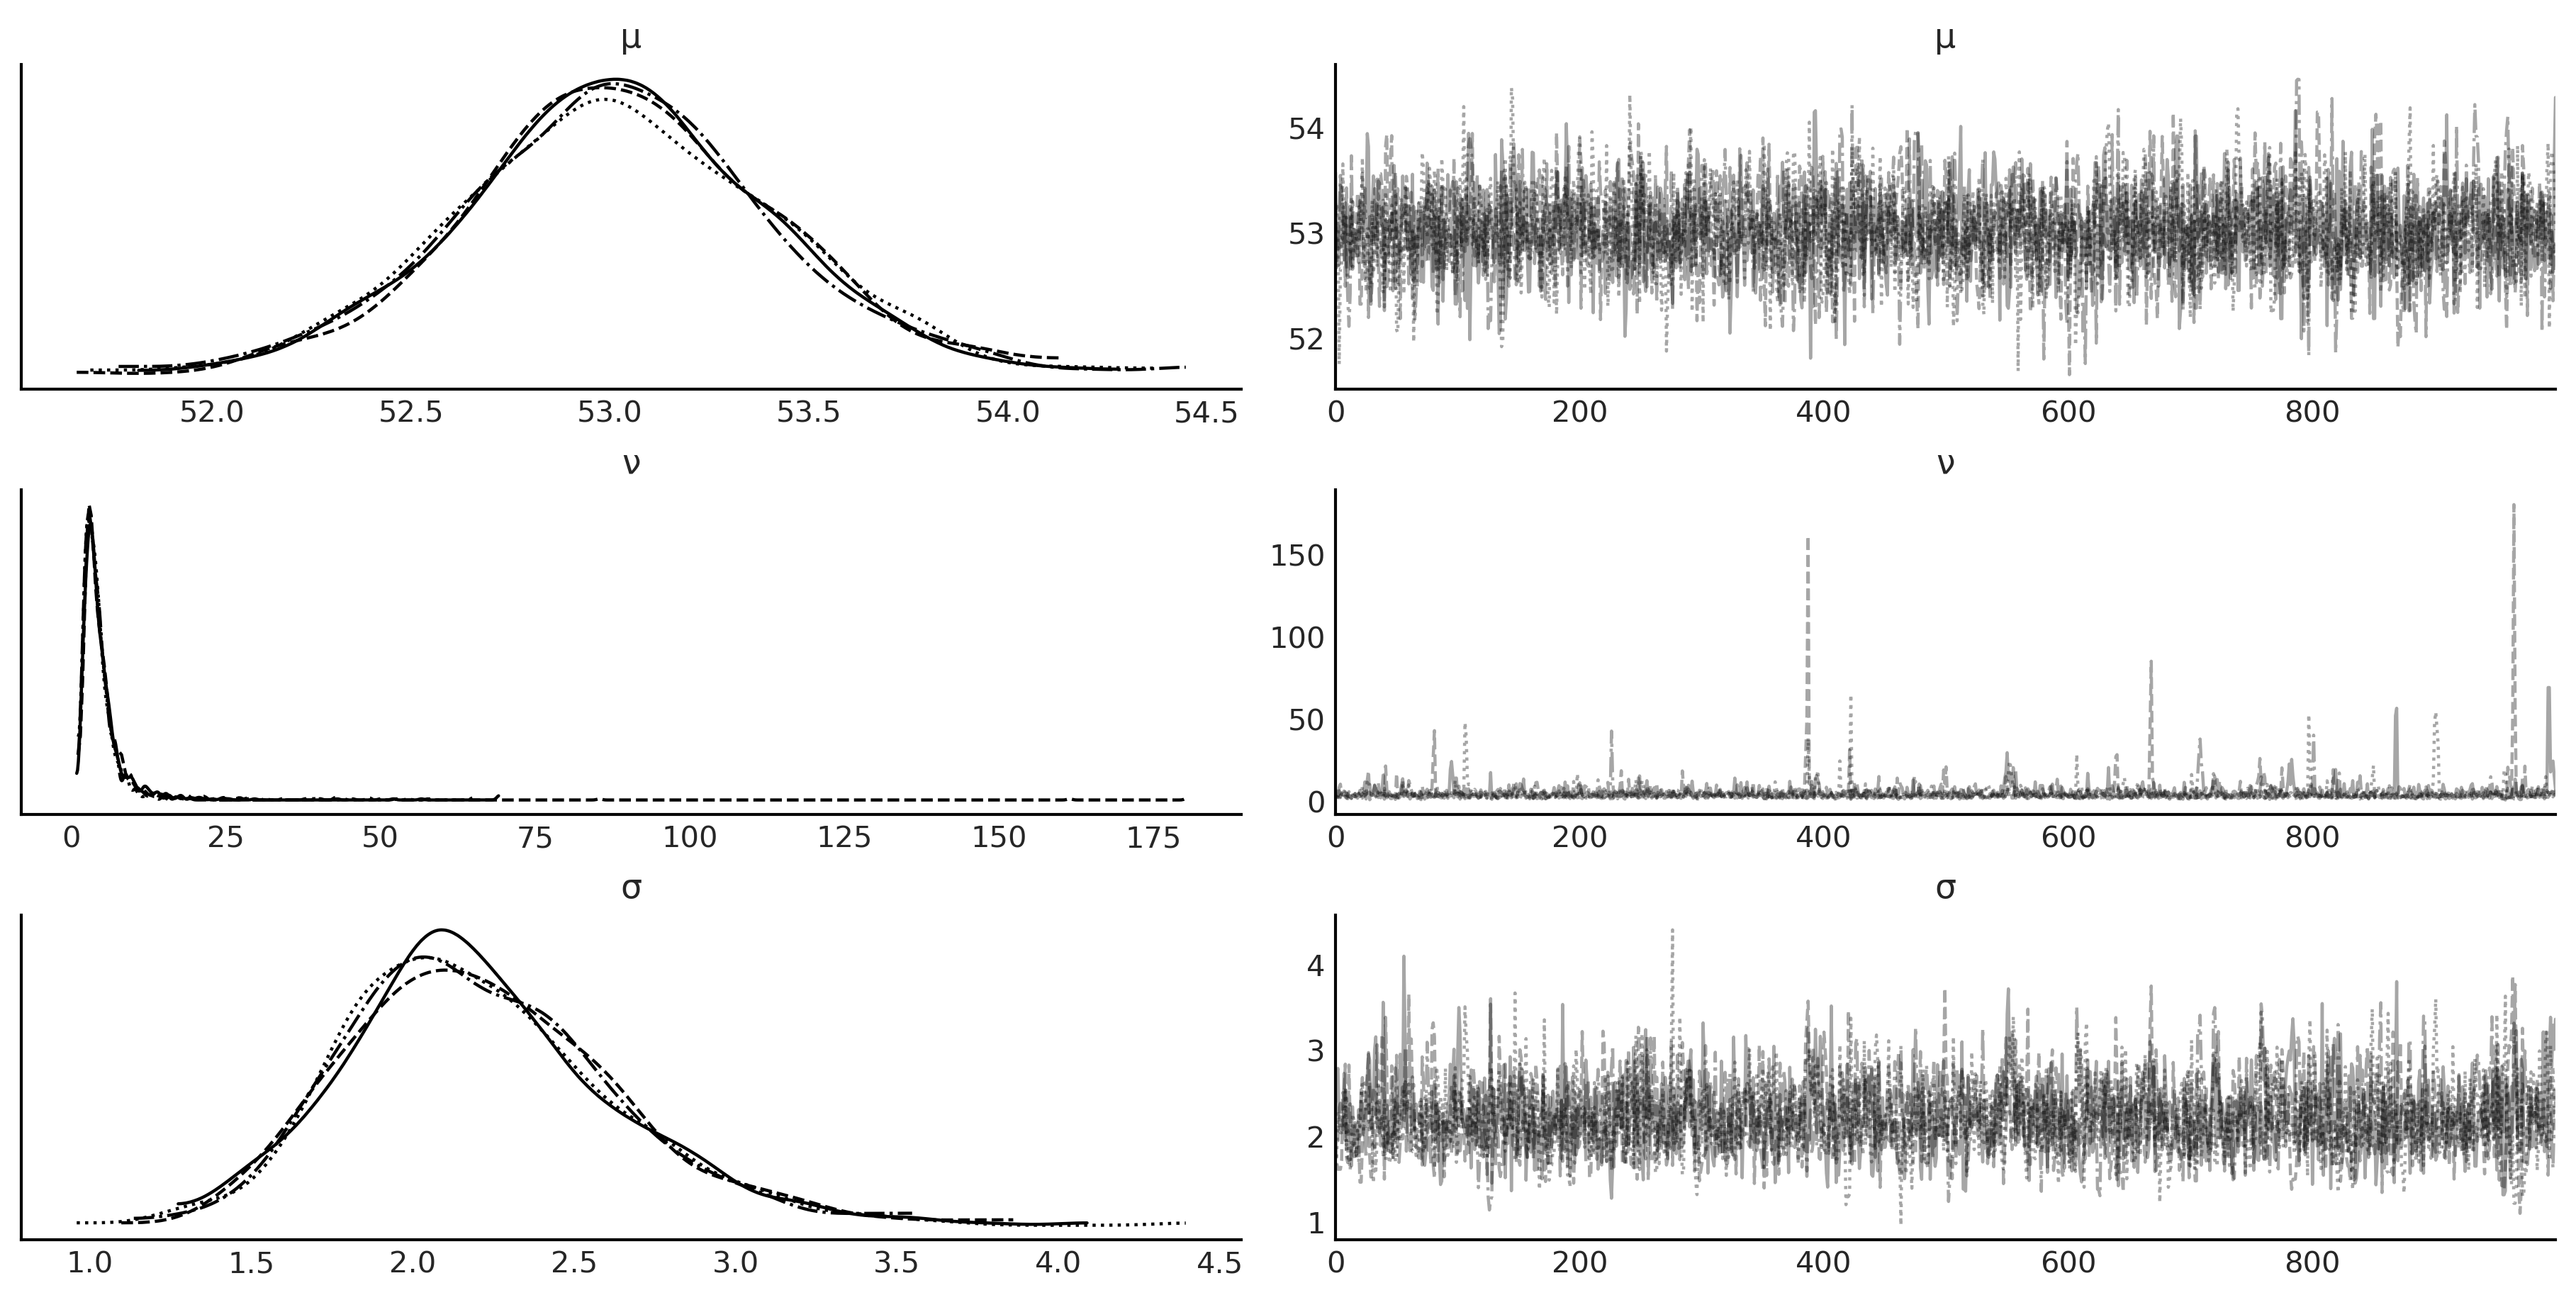

In [22]:
az.plot_trace(idata_t)

In [23]:
az.summary(idata_t, kind="stats", round_to=2)

mean    sd  hdi_3%  hdi_97%
μ  53.02  0.39   52.28    53.77
ν   4.87  5.99    1.17     9.63
σ   2.21  0.41    1.48     3.01

Sampling: [y]


Output()

(40.0, 70.0)

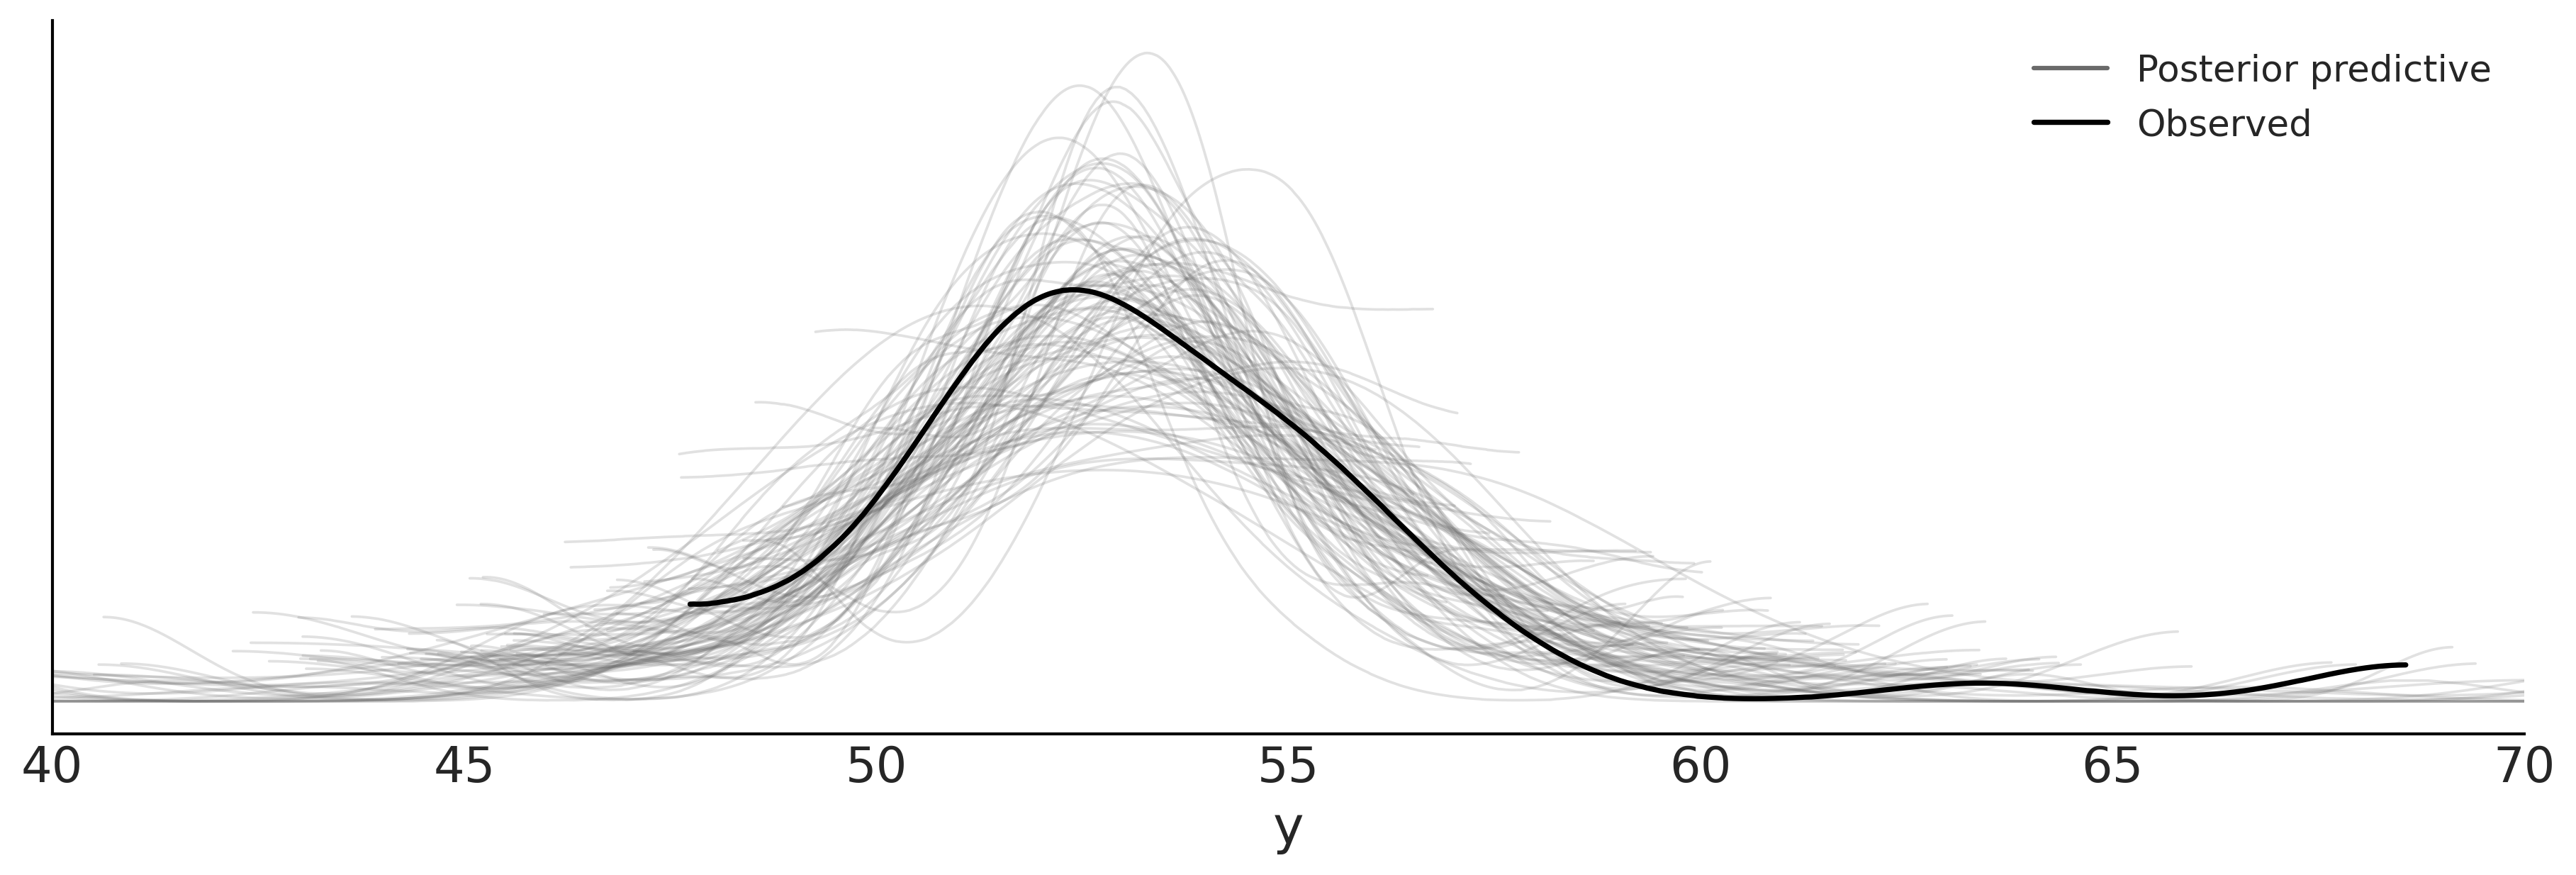

In [24]:
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True, random_seed=123)
ax = az.plot_ppc(idata_t, figsize=(12, 4), num_pp_samples=100, mean=False, colors=["C1", "C0", "C1"])
ax.set_xlim(40, 70)

In [25]:
idata_g

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [26]:
posterior = idata_g.posterior

In [27]:
posterior.sel(draw=0, chain=[0, 2])

<xarray.Dataset> Size: 56B
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 16B 0 2
    draw     int64 8B 0
Data variables:
    μ        (chain) float64 16B 53.22 53.32
    σ        (chain) float64 16B 3.941 3.351
Attributes:
    created_at:                 2024-06-01T20:10:40.727480+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.0
    sampling_time:              8.820136070251465
    tuning_steps:               1000

In [28]:
posterior.sel(draw=slice(0, 100))

<xarray.Dataset> Size: 7kB
Dimensions:  (chain: 4, draw: 101)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 808B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99 100
Data variables:
    μ        (chain, draw) float64 3kB 53.22 53.97 53.06 ... 53.27 53.61 54.19
    σ        (chain, draw) float64 3kB 3.941 3.623 3.054 ... 3.757 3.069 3.067
Attributes:
    created_at:                 2024-06-01T20:10:40.727480+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.0
    sampling_time:              8.820136070251465
    tuning_steps:               1000

In [29]:
posterior.mean()

<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    μ        float64 8B 53.49
    σ        float64 8B 3.544

In [30]:
posterior.mean("draw")

<xarray.Dataset> Size: 96B
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
Data variables:
    μ        (chain) float64 32B 53.51 53.48 53.47 53.48
    σ        (chain) float64 32B 3.552 3.546 3.534 3.544

In [31]:
stacked = az.extract(idata_g)

In [32]:
az.extract(idata_g, num_samples=100)

<xarray.Dataset> Size: 4kB
Dimensions:  (sample: 100)
Coordinates:
  * sample   (sample) object 800B MultiIndex
  * chain    (sample) int64 800B 0 1 3 3 3 3 3 2 1 0 0 ... 0 1 2 0 3 3 0 3 3 1 3
  * draw     (sample) int64 800B 646 78 504 120 595 793 ... 71 168 347 530 356
Data variables:
    μ        (sample) float64 800B 53.34 54.03 53.94 54.06 ... 53.43 53.56 53.98
    σ        (sample) float64 800B 4.2 3.485 3.476 3.896 ... 3.356 3.681 3.646
Attributes:
    created_at:                 2024-06-01T20:10:40.727480+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.0
    sampling_time:              8.820136070251465
    tuning_steps:               1000

In [33]:
tips = pd.read_csv("tips.csv")
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

array([<Axes: >], dtype=object)

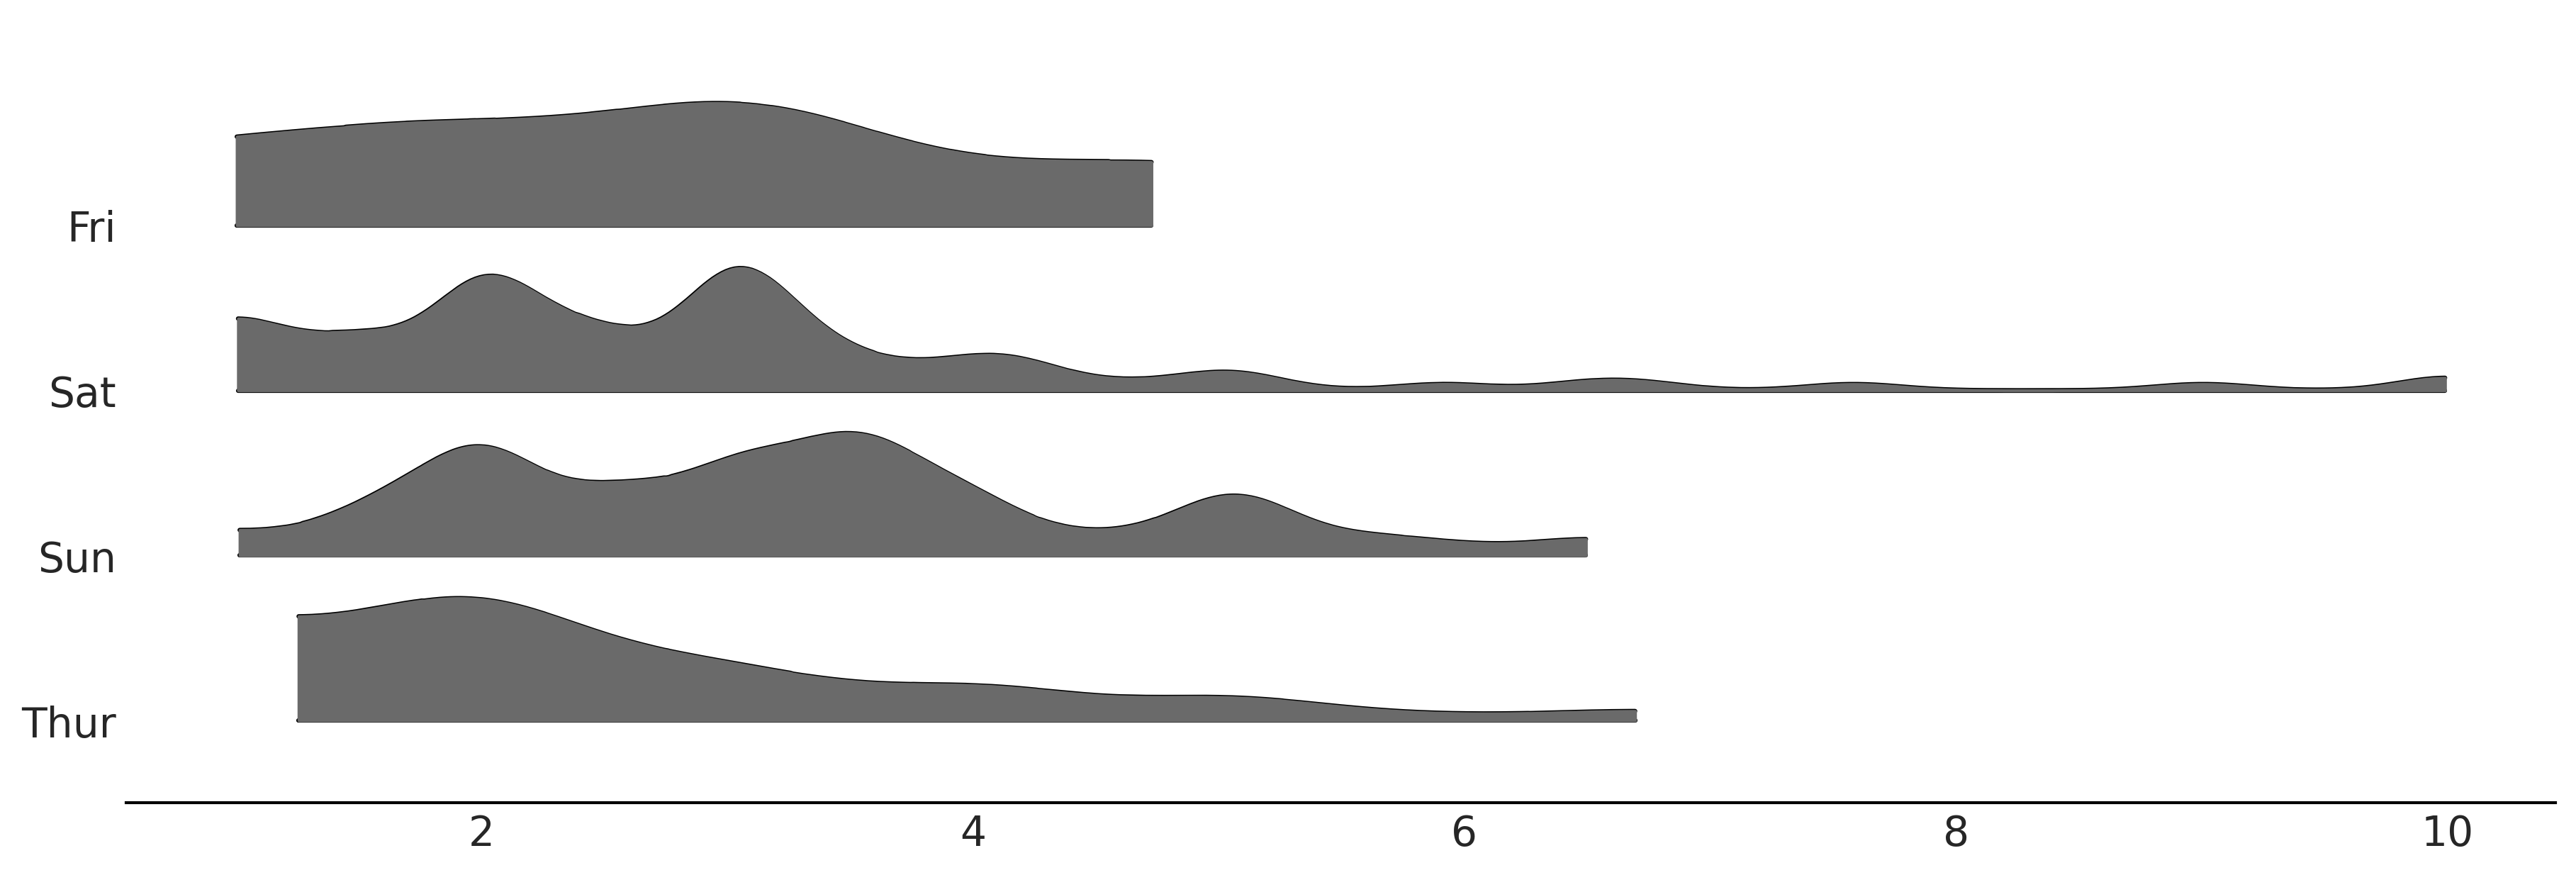

In [34]:
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               colors="C1",
               figsize=(12, 4))

In [35]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])
tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [36]:
with pm.Model() as comparing_groups:
    μ = pm.Normal("μ", mu=0, sigma=10, shape=4)
    σ = pm.HalfNormal("σ", sigma=10, shape=4)

    y = pm.Normal("y", mu=μ[idx], sigma=σ[idx], observed=tip)

In [37]:
coords = {"days": categories, "days_flat": categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="days")
    σ = pm.HalfNormal("σ", sigma=1, dims="days")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [y]


Output()

array([<Axes: xlabel='y\nSun'>, <Axes: xlabel='y\nSat'>,
       <Axes: xlabel='y\nThur'>, <Axes: xlabel='y\nFri'>], dtype=object)

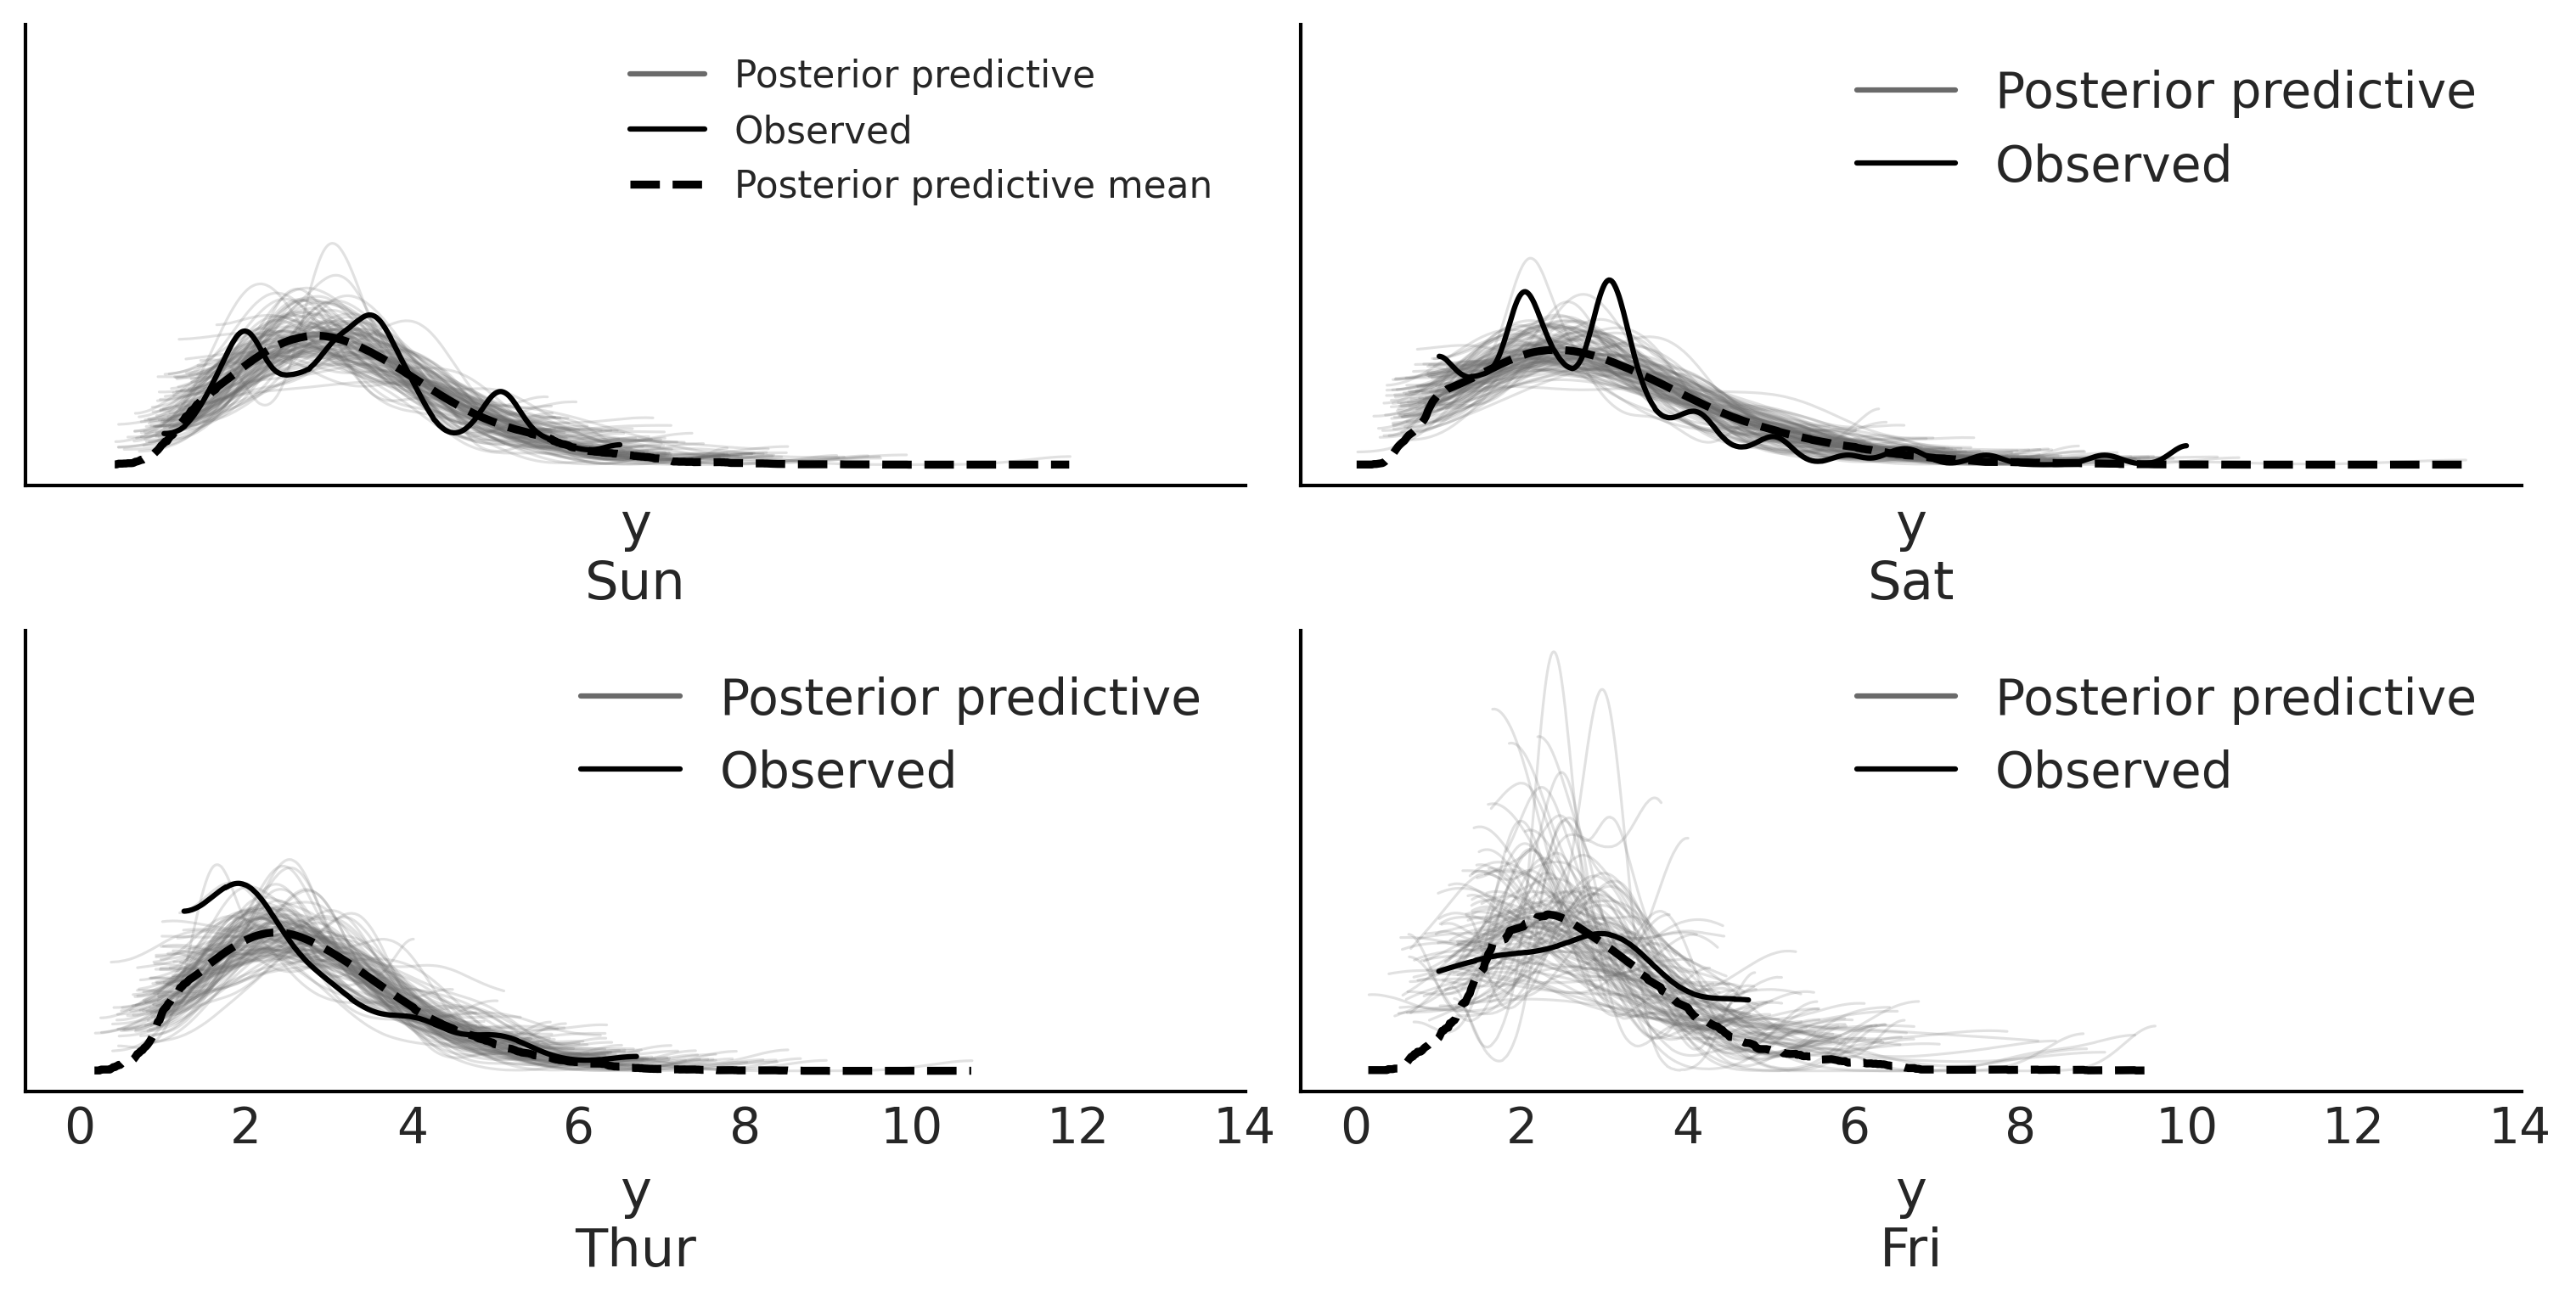

In [39]:
_, axes = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
az.plot_ppc(idata_cg, num_pp_samples=100, colors=["C1", "C0", "C0"], coords={"days_flat": [categories]}, flatten=[], ax=axes)

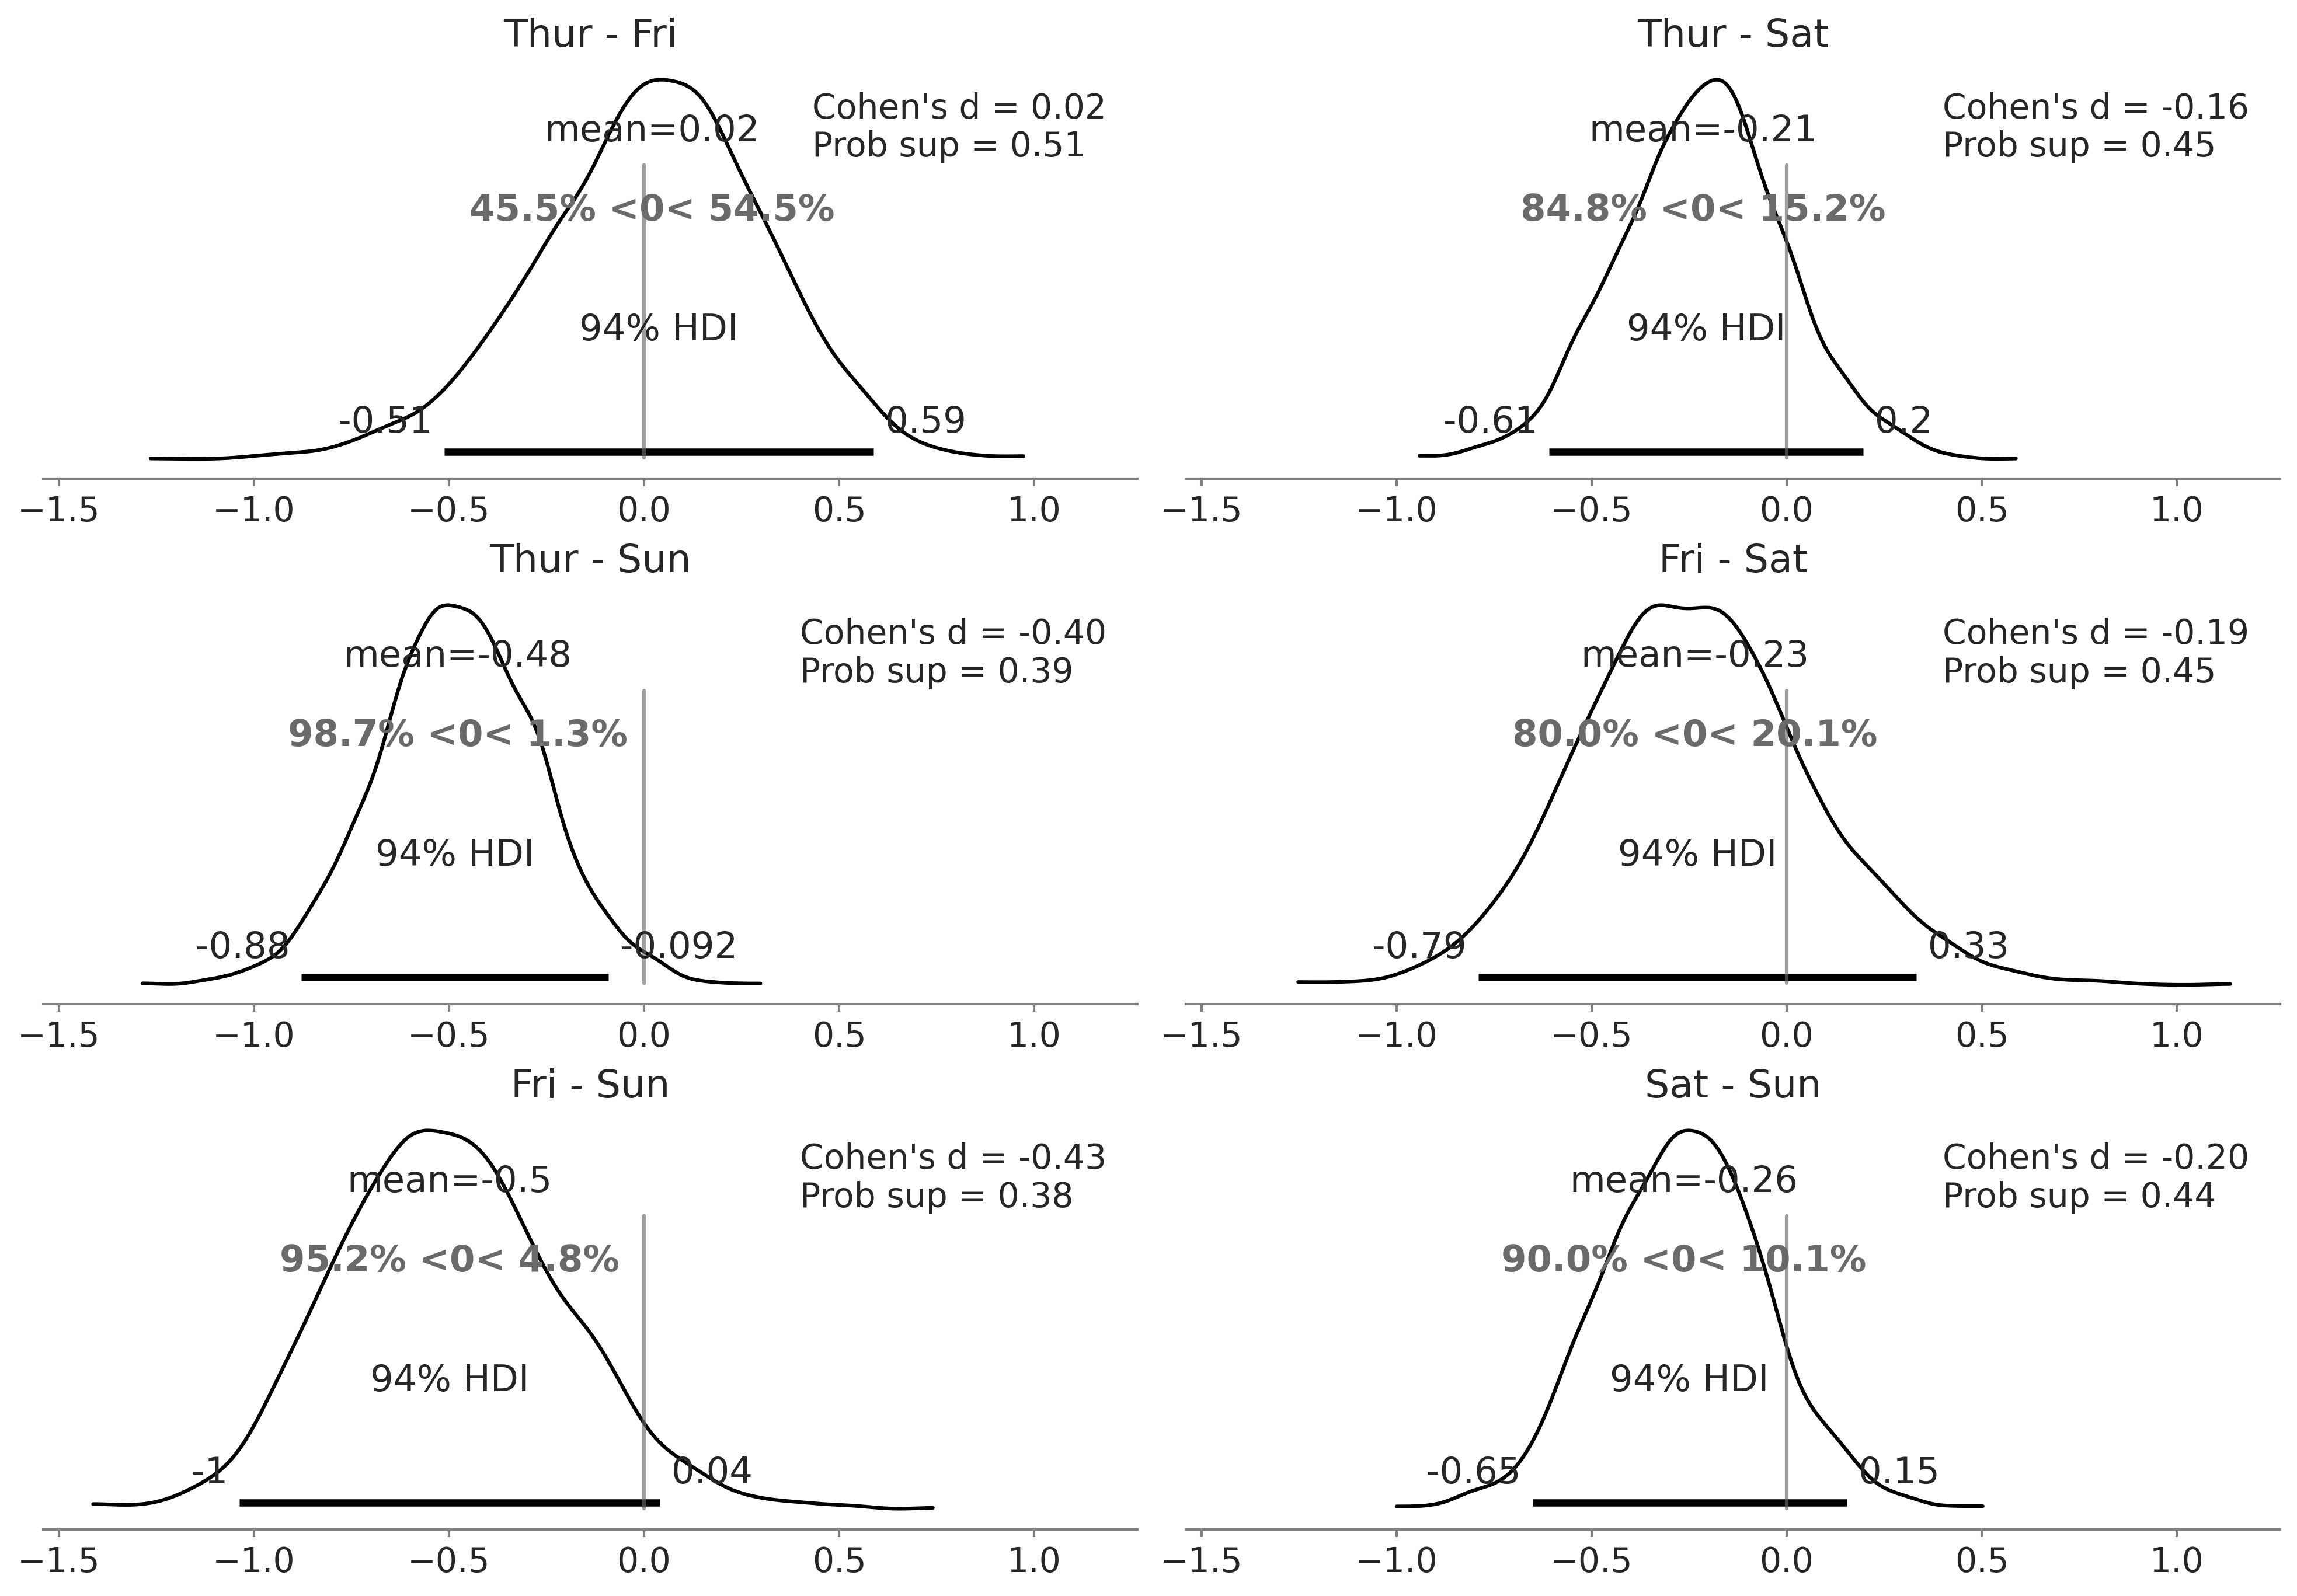

In [41]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["μ"].sel(days=i) - cg_posterior['μ'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["σ"].sel(days=i)**2 + 
                        cg_posterior["σ"].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)